In [1]:
import numpy as np
import matplotlib.pyplot as plt

#for GP
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct

In [2]:
from UserClass import *
from basic_environments import *
from basic_learners import *

In [3]:
%run DATA_users.py
%run DATA_parameters.py

In [4]:
user_classes = [C1, C2, C3]
real_contexts = [[(uc.F1, uc.F2)] for uc in user_classes ]
print(real_contexts)

[[(0, 0)], [(0, 1)], [(1, 0)]]


### Environment

In [5]:
#Obs: it is the same environment of step3, with self.user_class commented
class ContextEnvironment:
    def __init__(self, bids, prices, sigma_clicks, sigma_costs, margin_param, userclass):
        # self.userclass = userclass

        self.bidding_environment = BiddingEnvironment(bids, sigma_clicks, sigma_costs, userclass)
        self.pricing_environment = PricingEnvironment(prices, margin_param, userclass)


    def round(self, pulled_arm_bid, pulled_arm_price):
        n_daily_clicks, cum_daily_costs = self.bidding_environment.round(pulled_arm_bid)
        converted_clicks, reward = self.pricing_environment.round_step3(pulled_arm_price, n_daily_clicks, cum_daily_costs)

        return n_daily_clicks, cum_daily_costs, converted_clicks, reward

In [6]:
# class Environment:
#     def __init__(self, bids, prices, sigma_clicks, sigma_costs, margin_param, user_classes):
#         self.user_classes = user_classes
#         self.n_classes = len(user_classes)

#         self.single_environments = [ContextEnvironment(bids, prices, sigma_clicks, sigma_costs, margin_param, user_class) for user_class in user_classes]
#         self.features_list = [(user_class.F1,user_class.F2) for user_class in user_classes]

#     def round(self, pulled_arm_bid_list, pulled_arm_price_list, partition = [ [(0,0),(0,1),(1,0),(1,1)] ]):
#         """
#         pulled_arm_bid_list: list of integers
#             idx of the pulled arm ob the bids for each component of the partition

#         pulled_arm_price_list: list of integers
#             idx of the pulled arm ob the prices for each component of the partition

#         partition: list of lists of tuples of integers
#             notation: each element must contain a tuple indicating the partitioning for the features F1 and F2
#             e.g.
#                 if no partition ((the same as one set containing all possible features in the partition)): partition = [ [(0,0),(0,1),(1,0),(1,1)] ]
#                 if partition by splitting F1: partition = [ [(0,0),(0,1)] , [(1,0),(1,1)] ]

#         Note: pulled_arm_bid_list, pulled_arm_price_list, partition must have the same length
#         """

#         n_daily_clicks_list = []
#         cum_daily_costs_list = []
#         converted_clicks_list = []
#         reward_list = []
#         for i in range(self.n_classes):
#             user_F1 = self.user_classes[i].F1
#             user_F2 = self.user_classes[i].F2

#             idx_context = 0
#             for context in partition:
#                 if (user_F1,user_F2) in context:
#                     break
#                 idx_context += 1

#             n_daily_clicks, cum_daily_costs, converted_clicks, reward = self.single_environments[i].round(pulled_arm_bid_list[idx_context],
#                                                                                                           pulled_arm_price_list[idx_context])


#             n_daily_clicks_list.append(n_daily_clicks)
#             cum_daily_costs_list.append(cum_daily_costs)
#             converted_clicks_list.append(converted_clicks)
#             reward_list.append(reward)

#         return n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, self.features_list

In [7]:
class Environment:
    def __init__(self, bids, prices, sigma_clicks, sigma_costs, margin_param, user_classes):
        self.user_classes = user_classes
        self.n_classes = len(user_classes)
        self.user_environments = [ContextEnvironment(bids, prices, sigma_clicks, sigma_costs, margin_param, user_class) for user_class in user_classes]
        self.features_list = [(user_class.F1,user_class.F2) for user_class in user_classes]
        
        
    def round(self, pulled_arm_bid_list, pulled_arm_price_list, pulled_contexts):
        """
        pulled_arm_bid_list: list of integers
            idx of the pulled arm ob the bids for each component of the partition
        pulled_arm_price_list: list of integers
            idx of the pulled arm ob the prices for each component of the partition
        pulled_contexts: list of lists of tuples of integers
            notation: each element must contain a tuple indicating the partitioning for the features F1 and F2
            e.g.
                if no partition ((the same as one set containing all possible features in the partition)): partition = [ [(0,0),(0,1),(1,0),(1,1)] ]
                if partition by splitting F1: partition = [ [(0,0),(0,1)] , [(1,0),(1,1)] ]
        Note: pulled_arm_bid_list, pulled_arm_price_list, partition must have the same length
        About output: if pulled_contexts is valid (and is a partition), the length of each element in the output is the number of user classes 
        """
        
        n_daily_clicks_list = []
        cum_daily_costs_list = []
        converted_clicks_list = []
        reward_list = []
        for user, user_env in zip(self.user_classes, self.user_environments):
            for pulled_arm_bid, pulled_arm_price, context in zip(pulled_arm_bid_list, pulled_arm_price_list, pulled_contexts):
                n_daily_clicks, cum_daily_costs, converted_clicks, reward = user_env.round(pulled_arm_bid, pulled_arm_price)

                
                if (user.F1,user.F2) in context:
                    n_daily_clicks_list.append(n_daily_clicks)
                    cum_daily_costs_list.append(cum_daily_costs)
                    converted_clicks_list.append(converted_clicks)
                    reward_list.append(reward)
                    break

        if len(n_daily_clicks_list) != 3:########################################################################## TO DELETE FOR PRESENTATION
            print("SOMETHING WRONG: LOOK if you are using correctly class environment")
            
        return n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, self.features_list

## Learners

hp:
- we assume that the features we observe are binary  
    e.g. if we have 2 features: (0,0), (0,1), (1,0), (1,1) are the all the possible observations

### UCB

In [8]:
"""
Com: It is like of the Custom_S3_UCB_Learner with the following modifications:

Modifications:
- new attribute: context
- new method: update_from_batch
"""
#
## Convertion rate version ##
#
# class UCB_SingleContextLearner(Learner):# Obs: the curve of n_clicks and cost are always the same for any price we put, and the conversion rate is always the same for any bid we put
#     def __init__(self, arms_bids, arms_prices, margin_param, context, M = 1):
#         n_arms_bids = len(arms_bids)
#         n_arms_prices = len(arms_prices)
#         super().__init__(0)
#         self.rewards_per_arm = [[[] for i in range(n_arms_prices)] for j in range(n_arms_bids)] # Notation: reward is in rewards_per_arm[idx_bid][idx_price]

#         self.arms_prices = arms_prices
#         self.arms_bids = arms_bids

#         self.margin_param = margin_param

#         #learners:
#         self.n_daily_clicks_learner = GPUCB_Learner(arms_bids)
#         self.cum_daily_costs_learner = GPUCB_Learner(arms_bids)
#         self.conversion_rate_learner = UCB1_Learner(n_arms_prices, (0,M))

#         self.context = context# it is a list of tuples #


#     def pull_arm(self):
#         """
#         Notes:
#             The higher the conversion rate the higher the reward => I can pull directly the an arm of the prices for the highest alpha,
#             while the clicks and costs I have to evaluate them together and pull the bid that maximizes the reward

#             Question:
#                 Once I know the price arm to be pulled, for the bid arm, should I consider the upperbound of the conversion rate or just the mean of the conversion rate?
#                 -   choosing the mean of the conversion rate, there is just the uncertainty of related to the bid and the advertising curves
#                 -   choosing the upperbound of the conversion rate, it adds uncertainty related to the problem "conversion_rate(price)"
#                 --> I'm using the upperbound choice [but still an open question]
#         """
#         ub_clicks = self.n_daily_clicks_learner.means + self.n_daily_clicks_learner.sigmas
#         lb_costs = self.cum_daily_costs_learner.means - self.cum_daily_costs_learner.sigmas
#         ub_conversion_rates = self.conversion_rate_learner.empirical_means + self.conversion_rate_learner.confidence

#         ub = ub_conversion_rates * (self.arms_prices - self.margin_param)
#         idx_price_arm = np.random.choice(np.where(ub == ub.max())[0])

#         ub_reward = ub_clicks * ub[idx_price_arm] - lb_costs
#         idx_bid_arm = np.random.choice(np.where(ub_reward == ub_reward.max())[0])

#         return (idx_bid_arm, idx_price_arm)
    

#     def update_observations(self, pulled_arm_bid, pulled_arm_price, reward):
#         self.rewards_per_arm[pulled_arm_bid][pulled_arm_price].append(reward)
#         self.collected_rewards.append(reward)


#     def update(self, pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward):
#         """"
#         Obs: if n_daily_clicks = 0, we do not update the conversion_rate_learner
#         """
#         self.t += 1
#         self.update_observations(pulled_arm_bid, pulled_arm_price, reward)

#         self.n_daily_clicks_learner.update(pulled_arm_bid, n_daily_clicks)
#         self.cum_daily_costs_learner.update(pulled_arm_bid, cum_daily_costs)

#         if n_daily_clicks > 0:
#             alpha = converted_clicks / n_daily_clicks
#             self.conversion_rate_learner.update(pulled_arm_price, alpha)
#         else:
#             self.conversion_rate_learner.t += 1# need to be increased, because t is used in the computation of the upperbound

    
#     def update_from_batch(self, pulled_arm_bid_data, pulled_arm_price_data, n_daily_clicks_data, cum_daily_costs_data, converted_clicks_data, reward_data, time):######
#         """Obs:
#             - not all rewards are valid to update the convertion rate, because n_clicks can be 0 in some of values in n_daily_clicks_data
#         """
#         arms_of_alphas = []
#         alphas = []
#         for i, reward in enumerate(reward_data):
#             self.update_observations(pulled_arm_bid_data[i], pulled_arm_price_data[i], reward)
#             if n_daily_clicks_data[i] > 0:
#                 arms_of_alphas.append(pulled_arm_price_data[i])
#                 alphas.append(converted_clicks_data[i] / n_daily_clicks_data[i])

#         self.conversion_rate_learner.update_from_batch(arms_of_alphas, alphas, time)
#         self.n_daily_clicks_learner.update_from_batch(pulled_arm_bid_data, n_daily_clicks_data, time)
#         self.cum_daily_costs_learner.update_from_batch(pulled_arm_bid_data, cum_daily_costs_data, time)
#         self.t += time



class UCB_SingleContextLearner(Learner):# Obs: the curve of n_clicks and cost are always the same for any price we put, and the conversion rate is always the same for any bid we put
    def __init__(self, arms_bids, arms_prices, margin_param, context, M = 1):
        n_arms_bids = len(arms_bids)
        n_arms_prices = len(arms_prices)
        super().__init__(0)
        self.rewards_per_arm = [[[] for i in range(n_arms_prices)] for j in range(n_arms_bids)] # Notation: reward is in rewards_per_arm[idx_bid][idx_price]

        self.arms_prices = arms_prices
        self.arms_bids = arms_bids

        self.margin_param = margin_param

        #learners:
        self.n_daily_clicks_learner = GPUCB_Learner(arms_bids)
        self.cum_daily_costs_learner = GPUCB_Learner(arms_bids)
        # self.conversion_rate_learner = UCB1_Learner(n_arms_prices, (0,1))
        self.expected_margin_learner = UCB1_Learner(n_arms_prices, (0,M))

        self.context = context# it is a list of tuples #


    def pull_arm(self):
        """
        Notes:
            The higher the conversion rate the higher the reward => I can pull directly the an arm of the prices for the highest alpha,
            while the clicks and costs I have to evaluate them together and pull the bid that maximizes the reward

            Question:
                Once I know the price arm to be pulled, for the bid arm, should I consider the upperbound of the conversion rate or just the mean of the conversion rate?
                -   choosing the mean of the conversion rate, there is just the uncertainty of related to the bid and the advertising curves
                -   choosing the upperbound of the conversion rate, it adds uncertainty related to the problem "conversion_rate(price)"
                --> I'm using the upperbound choice [but still an open question]
        """
        ub_clicks = self.n_daily_clicks_learner.means + self.n_daily_clicks_learner.sigmas
        lb_costs = self.cum_daily_costs_learner.means - self.cum_daily_costs_learner.sigmas
        ub_expected_margin = self.expected_margin_learner.empirical_means + self.expected_margin_learner.confidence

        idx_price_arm = np.random.choice(np.where(ub_expected_margin == ub_expected_margin.max())[0])

        # ub_reward = ub_clicks * ub[idx_price_arm] - lb_costs
        ub_reward = ub_clicks * ub_expected_margin[idx_price_arm] - lb_costs
        idx_bid_arm = np.random.choice(np.where(ub_reward == ub_reward.max())[0])

        return (idx_bid_arm, idx_price_arm)
    

    def update_observations(self, pulled_arm_bid, pulled_arm_price, reward):
        self.rewards_per_arm[pulled_arm_bid][pulled_arm_price].append(reward)
        self.collected_rewards.append(reward)


    def update(self, pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward):
        """"
        Obs: if n_daily_clicks = 0, we do not update the conversion_rate_learner
        """
        self.t += 1
        self.update_observations(pulled_arm_bid, pulled_arm_price, reward)

        self.n_daily_clicks_learner.update(pulled_arm_bid, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm_bid, cum_daily_costs)

        if n_daily_clicks > 0:
            expected_margin = (converted_clicks / n_daily_clicks) * (self.arms_prices[pulled_arm_price] - self.margin_param)
            self.expected_margin_learner.update(pulled_arm_price, expected_margin)
        else:
            self.expected_margin_learner.t += 1# need to be increased, because t is used in the computation of the upperbound

    
    def update_from_batch(self, pulled_arm_bid_data, pulled_arm_price_data, n_daily_clicks_data, cum_daily_costs_data, converted_clicks_data, reward_data, time):######
        """Obs:
            - not all rewards are valid to update the convertion rate, because n_clicks can be 0 in some of values in n_daily_clicks_data
        """
        arms_of_alphas = []
        alphas = []
        for i, reward in enumerate(reward_data):
            self.update_observations(pulled_arm_bid_data[i], pulled_arm_price_data[i], reward)
            if n_daily_clicks_data[i] > 0:
                arms_of_alphas.append(pulled_arm_price_data[i])
                alphas.append((converted_clicks_data[i] / n_daily_clicks_data[i]) * (self.arms_prices[pulled_arm_price_data[i]] - self.margin_param))

        self.expected_margin_learner.update_from_batch(arms_of_alphas, alphas, time)
        self.n_daily_clicks_learner.update_from_batch(pulled_arm_bid_data, n_daily_clicks_data, time)
        self.cum_daily_costs_learner.update_from_batch(pulled_arm_bid_data, cum_daily_costs_data, time)
        self.t += time


In [9]:
class UCB_FixedContextsLearner(Learner):
    def __init__(self, arms_bids, arms_prices, margin_param, contexts, M = 1):
        super().__init__(0)# This learner learns by context and not by arms directly (the arms are inside the context_learners).

        self.collected_n_daily_clicks = []
        self.collected_cum_daily_costs = []
        self.collected_converted_clicks = []
        self.collected_features = []

        self.n_arms_bids = len(arms_bids)
        self.n_arms_prices = len(arms_prices)
        self.arms_prices = arms_prices
        self.arms_bids = arms_bids

        self.margin_param = margin_param
        self.contexts = contexts
        
        self.M = M # parameter of UCB
        # Learners:
        self.context_learners = [UCB_SingleContextLearner(arms_bids, arms_prices, margin_param, context, M) for context in self.contexts]


    def pull_arm(self):
        idx_bid_arm_list = []
        idx_price_arm_list = []
        for context_learner in self.context_learners:
            idx_bid_arm, idx_price_arm = context_learner.pull_arm()
            idx_bid_arm_list.append(idx_bid_arm)
            idx_price_arm_list.append(idx_price_arm)

        return (idx_bid_arm_list, idx_price_arm_list, self.contexts)


    def update_observations(self, n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list):
        # no self.rewards_per_arm[pulled_arm].append(reward) because no concept of an arm (the arms are used inside the context learners)
        self.collected_rewards.append(reward_list)
        self.collected_n_daily_clicks.append(n_daily_clicks_list)
        self.collected_cum_daily_costs.append(cum_daily_costs_list)
        self.collected_converted_clicks.append(converted_clicks_list)
        self.collected_features.append(features_list)
        

    def update(self, pulled_arm_bid_list, pulled_arm_price_list,
               n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list):
        """Obs: the length of the lists of the pulled arms are not necessary equal to those in the lists of clicks, costs, rewards and features"""
        self.t += 1
        self.update_observations(n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list)

        for i,context in enumerate(self.contexts):
            pulled_arm_bid_data = []
            pulled_arm_price_data = []

            n_daily_clicks_data = []
            cum_daily_costs_data = []
            converted_clicks_data = []
            reward_data = []

            for j,fts in enumerate(features_list):
                if fts in context:
                    pulled_arm_bid_data.append(pulled_arm_bid_list[i])
                    pulled_arm_price_data.append(pulled_arm_price_list[i])

                    n_daily_clicks_data.append(n_daily_clicks_list[j])
                    cum_daily_costs_data.append(cum_daily_costs_list[j])
                    converted_clicks_data.append(converted_clicks_list[j])
                    reward_data.append(reward_list[j])

            self.context_learners[i].update_from_batch(pulled_arm_bid_data, pulled_arm_price_data,
                                                       n_daily_clicks_data, cum_daily_costs_data, converted_clicks_data, reward_data, 1)

In [10]:
class UCB_ContextsGreadyLearner(UCB_FixedContextsLearner):
    def __init__(self, arms_bids, arms_prices, margin_param, window_context, M = 1): 
        # self.n_features = 2
        contexts = [ [(0,0),(0,1),(1,0),(1,1)] ] # i.e. just one contexts containing all the possible combinations of features
        super().__init__(arms_bids, arms_prices, margin_param, contexts, M = M)
        # self.features_partitioned = np.zeros(self.n_features)#notation 0 if that feature is not related to the partition, 1 if it is

        self.window_context = window_context

        # we need
        self.collected_pulled_arm_bid = []# to save the idx of the pulled arms ordered by features not by context
        self.collected_pulled_arm_price = []# to save the idx of the pulled arms ordered by features not by context
        #COM: we need to collect all these informations because they are used when a new context structure is built


    # def pull_arm(self): the same of the super class

    def collect_pulled_arms(self, pulled_arm_bid_list, pulled_arm_price_list, features_list):
        idx_bid_list = []#[[] for fts in features_list]
        idx_price_list =  []#[[] for fts in features_list]

        for fts in features_list:#i,fts in enumerate(features_list):
            for j,context in enumerate(self.contexts):
                if fts in context:
                    # idx_bid_list[i] = pulled_arm_bid_list[j]
                    # idx_price_list[i] = pulled_arm_price_list[j]
                    idx_bid_list.append(pulled_arm_bid_list[j])
                    idx_price_list.append(pulled_arm_price_list[j])
                    break

        self.collected_pulled_arm_bid.append(idx_bid_list)
        self.collected_pulled_arm_price.append(idx_price_list)


    def get_total_lb_from_contexts(self, context_learners):
        lb_reward_tot = 0
        for context_learner in context_learners:
            lb_clicks = min(context_learner.n_daily_clicks_learner.means - context_learner.n_daily_clicks_learner.sigmas)
            lb_convertion_rate = min(context_learner.conversion_rate_learner.empirical_means - context_learner.conversion_rate_learner.confidence)
            ub_costs = max(context_learner.cum_daily_costs_learner.means + context_learner.cum_daily_costs_learner.sigmas)

            lb_reward = lb_clicks * lb_convertion_rate * self.margin - ub_costs
            lb_reward_tot += lb_reward
        return lb_reward_tot


    def get_total_lb_from_contexts(self, context_learners):
        lb_reward_tot = 0
        for context_learner in context_learners:            
            idx_bid_arm, idx_price_arm = context_learner.pull_arm()
            
            lb_clicks = context_learner.n_daily_clicks_learner.means[idx_bid_arm] - 1.65 * context_learner.n_daily_clicks_learner.sigmas[idx_bid_arm]
            
            # convertion_rate_hat = ...
            dim_setdata = len(context_learner.expected_margin_learner.rewards_per_arm[idx_price_arm])
            expected_margin_hat = context_learner.expected_margin_learner.empirical_means[idx_price_arm]
            lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))
            
            ub_costs = context_learner.cum_daily_costs_learner.means[idx_bid_arm] + 1.65 * context_learner.cum_daily_costs_learner.sigmas[idx_bid_arm]
            

            lb_reward = lb_clicks * lb_convertion_rate * (self.arms_prices[idx_price_arm] - self.margin_param) - ub_costs
            lb_reward_tot += lb_reward
        return lb_reward_tot


    def generate_partitions(self):
        """Greedy approach:
        returns a list of the partitions to be evaluated
        """
        ## General approach if n_features = any number ??
        # something that uses self.features_partitioned and self.contexts to generate the partitions
        # and return the partitions and the indicators of which features are used for those partitions
        #
        # since n_features = 2 it is just:
        partitions_list = []
        if len(self.contexts) == 1:
            partitions_list = [ [[(0,0),(0,1)], [(1,0),(1,1)]], [[(0,0),(1,0)], [(0,1),(1,1)]] ]
        if len(self.contexts) == 2:
            partitions_list = [ [[(0,0)], [(0,1)], [(1,0)], [(1,1)]] ]
        if len(self.contexts) == 4:
            partitions_list = []

        return partitions_list


    def update(self, pulled_arm_bid_list, pulled_arm_price_list,
               n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list):
        """Obs: length of the lists of the pulled arms not necessary equal to those in the lists of clicks costs rewards and features"""

        super().update(pulled_arm_bid_list, pulled_arm_price_list, n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list)
        self.collect_pulled_arms(pulled_arm_bid_list, pulled_arm_price_list, features_list)

        if self.t % self.window_context == 0: #then consider to change the structure of the contexts
            print("evaluating change at time", self.t)
            lb_reward_current_partition = self.get_total_lb_from_contexts(self.context_learners)
            partitions_to_evaluate = self.generate_partitions()

            for partition in partitions_to_evaluate:
                new_context_learners = [UCB_SingleContextLearner(self.arms_bids, self.arms_prices, self.margin_param, context, self.M) for context in partition]

                for i,context in enumerate(partition):
                    # finding the data to fit the context learner:
                    pulled_arm_bid_data = []
                    pulled_arm_price_data = []
                    n_daily_clicks_data = []
                    cum_daily_costs_data = []
                    converted_clicks_data = []
                    reward_data = []
                    for t, collected_features_t in enumerate(self.collected_features):
                        for j, fts in enumerate(collected_features_t):
                            if fts in context:
                                pulled_arm_bid_data.append(self.collected_pulled_arm_bid[t][j])
                                pulled_arm_price_data.append(self.collected_pulled_arm_price[t][j])

                                n_daily_clicks_data.append(self.collected_n_daily_clicks[t][j])
                                cum_daily_costs_data.append(self.collected_cum_daily_costs[t][j])
                                converted_clicks_data.append(self.collected_converted_clicks[t][j])
                                reward_data.append(self.collected_rewards[t][j])

                    # fitting the context learner
                    new_context_learners[i].update_from_batch(pulled_arm_bid_data, pulled_arm_price_data,
                                                              n_daily_clicks_data, cum_daily_costs_data, converted_clicks_data, reward_data, self.t)
                                                              
                ## evaluate lower bound of the new partition
                lb_reward_new_partition = self.get_total_lb_from_contexts(new_context_learners)
                print("  current lb reward = ", lb_reward_current_partition)
                print("  candidate partition lb reward = ", lb_reward_new_partition)

                # Now we need to compare this lb with the lb of the current partition to choose which is better
                if lb_reward_new_partition > lb_reward_current_partition:
                    self.contexts = partition.copy()
                    self.context_learners = new_context_learners
                    lb_reward_current_partition = lb_reward_new_partition

                    print(f'PARTITION CHANGED AT TIME {self.t}')

### TS

In [11]:
"""
Com: It is like of the Custom_S3_TS_Learner with the following modifications:

Modifications:
- new attribute: context (actually, not really necesary)
- new method: update_from_batch
"""

class TS_SingleContextLearner(Learner):
    def __init__(self, arms_bids, arms_prices, margin_param, context):
        n_arms_bids = len(arms_bids)
        n_arms_prices = len(arms_prices)
        
        super().__init__(0)
        self.rewards_per_arm = [[[] for i in range(n_arms_prices)] for j in range(n_arms_bids)]

        self.arms_prices = arms_prices
        self.arms_bids = arms_bids
        
        self.margin_param = margin_param

        #learners
        self.n_daily_clicks_learner = GPTS_Learner(arms_bids)
        self.cum_daily_costs_learner = GPTS_Learner(arms_bids)
        self.conversion_rate_learner = Binomial_TS_Learner(n_arms_prices)

        self.context = context# it is a list of tuples #
        

    def pull_arm(self):
        sampled_conversion_rates = np.random.beta( self.conversion_rate_learner.beta_parameters[:,0], self.conversion_rate_learner.beta_parameters[:,1] )
        sampled_clicks = np.random.normal(self.n_daily_clicks_learner.means, self.n_daily_clicks_learner.sigmas)
        sampled_costs = np.random.normal(self.cum_daily_costs_learner.means, self.cum_daily_costs_learner.sigmas)
        
        idx_price_arm = np.argmax(sampled_conversion_rates * (self.arms_prices - self.margin_param))

        idx_bid_arm = np.argmax(
            sampled_clicks * sampled_conversion_rates[idx_price_arm] * (self.arms_prices[idx_price_arm] - self.margin_param) - sampled_costs
            )
        
        return idx_bid_arm, idx_price_arm
    
    
    def update_observations(self, pulled_arm_bid, pulled_arm_price, reward):
        self.rewards_per_arm[pulled_arm_bid][pulled_arm_price].append(reward)
        self.collected_rewards.append(reward)
        

    def update(self, pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward):
        """"
        Obs: if n_daily_clicks = 0, we do not update the conversion_rate_learner
        """
        self.t += 1
        self.update_observations(pulled_arm_bid, pulled_arm_price, reward)

        self.n_daily_clicks_learner.update(pulled_arm_bid, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm_bid, cum_daily_costs)

        if n_daily_clicks > 0:
            self.conversion_rate_learner.update(pulled_arm_price, converted_clicks, n_daily_clicks)
        else:
            self.conversion_rate_learner.t += 1# need to be increased, because t is used in the computation of the upperbound
            

    def update_from_batch(self, pulled_arm_bid_data, pulled_arm_price_data, n_daily_clicks_data, cum_daily_costs_data, converted_clicks_data, reward_data, time):
        """Obs:
            - not all rewards are valid to update the convertion rate, because n_clicks can be 0 in some of values in n_daily_clicks_data
        """
        arms_data = []
        k_data = []
        k_max_data = []
        for i, reward in enumerate(reward_data):
            self.update_observations(pulled_arm_bid_data[i], pulled_arm_price_data[i], reward)
            if n_daily_clicks_data[i] > 0:
                arms_data.append(pulled_arm_price_data[i])
                k_data.append(converted_clicks_data[i])
                k_max_data.append(n_daily_clicks_data[i])

        self.conversion_rate_learner.update_from_batch(arms_data, k_data, k_max_data, time)
        self.n_daily_clicks_learner.update_from_batch(pulled_arm_bid_data, n_daily_clicks_data, time)
        self.cum_daily_costs_learner.update_from_batch(pulled_arm_bid_data, cum_daily_costs_data, time)
        self.t += time

In [12]:
class TS_FixedContextsLearner(Learner):
    def __init__(self, arms_bids, arms_prices, margin_param, contexts):
        super().__init__(0)# This learner learns by context and not by arms directly (the arms are inside the context_learners).

        self.collected_n_daily_clicks = []
        self.collected_cum_daily_costs = []
        self.collected_converted_clicks = []
        self.collected_features = []

        self.n_arms_bids = len(arms_bids)
        self.n_arms_prices = len(arms_prices)
        self.arms_prices = arms_prices
        self.arms_bids = arms_bids

        self.margin_param = margin_param
        self.contexts = contexts

        # Learners:
        self.context_learners = [TS_SingleContextLearner(arms_bids, arms_prices, margin_param, context) for context in self.contexts]


    def pull_arm(self):
        idx_bid_arm_list = []
        idx_price_arm_list = []
        for context_learner in self.context_learners:
            idx_bid_arm, idx_price_arm = context_learner.pull_arm()
            idx_bid_arm_list.append(idx_bid_arm)
            idx_price_arm_list.append(idx_price_arm)

        return idx_bid_arm_list, idx_price_arm_list, self.contexts


    def update_observations(self, n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list):
        # no self.rewards_per_arm[pulled_arm].append(reward) because no concept of an arm (the arms are used inside the context learners)
        self.collected_rewards.append(reward_list)
        self.collected_n_daily_clicks.append(n_daily_clicks_list)
        self.collected_cum_daily_costs.append(cum_daily_costs_list)
        self.collected_converted_clicks.append(converted_clicks_list)
        self.collected_features.append(features_list)
        

    def update(self, pulled_arm_bid_list, pulled_arm_price_list,
               n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list):
        """Obs: the length of the lists of the pulled arms are not necessary equal to those in the lists of clicks, costs, rewards and features"""
        self.t += 1
        self.update_observations(n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list)

        for i,context in enumerate(self.contexts):
            pulled_arm_bid_data = []
            pulled_arm_price_data = []

            n_daily_clicks_data = []
            cum_daily_costs_data = []
            converted_clicks_data = []
            reward_data = []
            for j,fts in enumerate(features_list):
                if fts in context:
                    pulled_arm_bid_data.append(pulled_arm_bid_list[i])
                    pulled_arm_price_data.append(pulled_arm_price_list[i])

                    n_daily_clicks_data.append(n_daily_clicks_list[j])
                    cum_daily_costs_data.append(cum_daily_costs_list[j])
                    converted_clicks_data.append(converted_clicks_list[j])
                    reward_data.append(reward_list[j])

            self.context_learners[i].update_from_batch(pulled_arm_bid_data, pulled_arm_price_data,
                                                       n_daily_clicks_data, cum_daily_costs_data, converted_clicks_data, reward_data, 1)

In [13]:
class TS_ContextsGreedyLearner(TS_FixedContextsLearner):
    def __init__(self, arms_bids, arms_prices, margin_param, window_context):
        # self.n_features = 2
        contexts = [ [(0,0),(0,1),(1,0),(1,1)] ] # i.e. just one contexts containing all the possible combinations of features
        super().__init__(arms_bids, arms_prices, margin_param, contexts)
        # self.features_partitioned = np.zeros(self.n_features)#notation 0 if that feature is not related to the partition, 1 if it is

        self.window_context = window_context

        # we need
        self.collected_pulled_arm_bid = []# to save the idx of the pulled arms ordered by features not by context
        self.collected_pulled_arm_price = []# to save the idx of the pulled arms ordered by features not by context
        #COM: we need to collect all these informations because they are used when a new context structure is built


    # def pull_arm(self): the same of the super class

    def collect_pulled_arms(self, pulled_arm_bid_list, pulled_arm_price_list, features_list):
        idx_bid_list = []#[[] for fts in features_list]
        idx_price_list =  []#[[] for fts in features_list]

        for fts in features_list:#i,fts in enumerate(features_list):
            for j,context in enumerate(self.contexts):
                if fts in context:
                    # idx_bid_list[i] = pulled_arm_bid_list[j]
                    # idx_price_list[i] = pulled_arm_price_list[j]
                    idx_bid_list.append(pulled_arm_bid_list[j])
                    idx_price_list.append(pulled_arm_price_list[j])
                    break

        self.collected_pulled_arm_bid.append(idx_bid_list)
        self.collected_pulled_arm_price.append(idx_price_list)


    def get_total_lb_from_contexts(self, context_learners):
        lb_reward_tot = 0
        for context_learner in context_learners:
            idx_bid_arm, idx_price_arm = context_learner.pull_arm()
            
            lb_clicks = context_learner.n_daily_clicks_learner.means[idx_bid_arm] - 1.65 * context_learner.n_daily_clicks_learner.sigmas[idx_bid_arm]
            
            dim_setdata_cr = (context_learner.conversion_rate_learner.beta_parameters[idx_price_arm,0] + context_learner.conversion_rate_learner.beta_parameters[idx_price_arm,1])
            convertion_rate_hat = context_learner.conversion_rate_learner.beta_parameters[idx_price_arm,0] / dim_setdata_cr
            lb_convertion_rate = convertion_rate_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata_cr))
            
            ub_costs = context_learner.cum_daily_costs_learner.means[idx_bid_arm] + 1.65 * context_learner.cum_daily_costs_learner.sigmas[idx_bid_arm]

            lb_reward = lb_clicks * lb_convertion_rate * (self.arms_prices[idx_price_arm] - self.margin_param) - ub_costs
            lb_reward_tot += lb_reward
        return lb_reward_tot


    def generate_partitions(self):
        """Greedy approach:
        returns a list of the partitions to be evaluated
        """
        ## General approach if n_features = any number ??
        # something that uses self.features_partitioned and self.contexts to generate the partitions
        # and return the partitions and the indicators of which features are used for those partitions
        #
        # since n_features = 2 it is just:
        partitions_list = []
        if len(self.contexts) == 1:
            partitions_list = [ [[(0,0),(0,1)], [(1,0),(1,1)]], [[(0,0),(1,0)], [(0,1),(1,1)]] ]
        if len(self.contexts) == 2:
            partitions_list = [ [[(0,0)], [(0,1)], [(1,0)], [(1,1)]] ]
        if len(self.contexts) == 4:
            partitions_list = []

        return partitions_list


    def update(self, pulled_arm_bid_list, pulled_arm_price_list,
               n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list):
        """Obs: length of the lists of the pulled arms not necessary equal to those in the lists of clicks costs rewards and features"""

        super().update(pulled_arm_bid_list, pulled_arm_price_list, n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list)
        self.collect_pulled_arms(pulled_arm_bid_list, pulled_arm_price_list, features_list)

        if self.t % self.window_context == 0: #then consider to change the structure of the contexts
            print("evaluating change at time", self.t)
            lb_reward_current_partition = self.get_total_lb_from_contexts(self.context_learners)
            partitions_to_evaluate = self.generate_partitions()

            for partition in partitions_to_evaluate:
                new_context_learners = [TS_SingleContextLearner(self.arms_bids, self.arms_prices, self.margin_param, context) for context in partition]

                for i,context in enumerate(partition):
                    # finding the data to fit the context learner:
                    pulled_arm_bid_data = []
                    pulled_arm_price_data = []
                    n_daily_clicks_data = []
                    cum_daily_costs_data = []
                    converted_clicks_data = []
                    reward_data = []
                    for t, collected_features_t in enumerate(self.collected_features):
                        for j, fts in enumerate(collected_features_t):
                            if fts in context:
                                pulled_arm_bid_data.append(self.collected_pulled_arm_bid[t][j])
                                pulled_arm_price_data.append(self.collected_pulled_arm_price[t][j])

                                n_daily_clicks_data.append(self.collected_n_daily_clicks[t][j])
                                cum_daily_costs_data.append(self.collected_cum_daily_costs[t][j])
                                converted_clicks_data.append(self.collected_converted_clicks[t][j])
                                reward_data.append(self.collected_rewards[t][j])

                    # fitting the context learner
                    new_context_learners[i].update_from_batch(pulled_arm_bid_data, pulled_arm_price_data,
                                                              n_daily_clicks_data, cum_daily_costs_data, converted_clicks_data, reward_data, self.t)

                ## evaluate lower bound of the new partition
                lb_reward_new_partition = self.get_total_lb_from_contexts(new_context_learners)
                print("  current lb reward = ", lb_reward_current_partition)
                print("  candidate partition lb reward = ", lb_reward_new_partition)

                # Now we need to compare this lb with the lb of the current partition to choose which is better
                if lb_reward_new_partition > lb_reward_current_partition:
                    self.contexts = partition.copy()
                    self.context_learners = new_context_learners
                    lb_reward_current_partition = lb_reward_new_partition

                    print(f'PARTITION CHANGED AT TIME {self.t}')

# Simulations

Parameters

In [14]:
T = 60
n_experiments = 20 #50

# context parameters:
window_context = 14


# param ucb
M = 12

Clairvoyant

In [15]:
opt_list = []

for i, userclass in enumerate(user_classes):
    opt_arm_price = np.argmax(userclass.conversion_rate_function(PRICES) * (PRICES - MARGIN_PARAM))
    opt_price = PRICES[opt_arm_price]
    opt_conversion_rate = userclass.conversion_rate_function(opt_price)


    opt_bid_arm = np.argmax(userclass.n_daily_clicks_function(BIDS) * opt_conversion_rate * (opt_price - MARGIN_PARAM) - userclass.cum_daily_costs_function(BIDS))
    opt_bid = BIDS[opt_bid_arm]
    opt_n_daily_clicks = userclass.n_daily_clicks_function(opt_bid)
    opt_cum_daily_costs = userclass.cum_daily_costs_function(opt_bid)


    opt = opt_n_daily_clicks * opt_conversion_rate * (opt_price - MARGIN_PARAM) - opt_cum_daily_costs

    opt_list.append(opt)

    print(f'User class C{i}, context {real_contexts[i]}')
    print("- optimal bid: ", opt_bid)
    print("- optimal price: ", opt_price)
    print()
    print("- n_daily_clicks on the optimal bid: ", opt_n_daily_clicks)
    print("- cum_daily_costs on the optimal bid: ", opt_cum_daily_costs)
    print("- convertion rate on the optimal price: ", opt_conversion_rate)
    print()
    print("- optimal reward: ", opt)
    print()
    print()

User class C0, context [(0, 0)]
- optimal bid:  6.0
- optimal price:  60

- n_daily_clicks on the optimal bid:  100.0
- cum_daily_costs on the optimal bid:  360.0
- convertion rate on the optimal price:  0.5458775937413701

- optimal reward:  731.7551874827402


User class C1, context [(0, 1)]
- optimal bid:  6.0
- optimal price:  50

- n_daily_clicks on the optimal bid:  100.0
- cum_daily_costs on the optimal bid:  360.0
- convertion rate on the optimal price:  0.9

- optimal reward:  540.0


User class C2, context [(1, 0)]
- optimal bid:  6.0
- optimal price:  80

- n_daily_clicks on the optimal bid:  100.0
- cum_daily_costs on the optimal bid:  360.0
- convertion rate on the optimal price:  0.8531249999999999

- optimal reward:  3052.4999999999995




## Case: known structure

### UCB - known context structure

In [16]:
## UCB learner

ucb_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(BIDS, PRICES, SIGMA_CLICKS, SIGMA_COSTS, MARGIN_PARAM, user_classes)
    ucb_learner = UCB_FixedContextsLearner(BIDS, PRICES, MARGIN_PARAM, real_contexts, M)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, converted_clicks, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ucb_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward, features)

    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

0.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


5.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


10.0%
15.0%
20.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

25.0%
30.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


35.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


40.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


45.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


50.0%
55.00000000000001%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


65.0%
70.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


75.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site

80.0%
85.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site

90.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


95.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Plot

In [17]:
rewards_simulations = np.array(ucb_rewards_per_experiment)

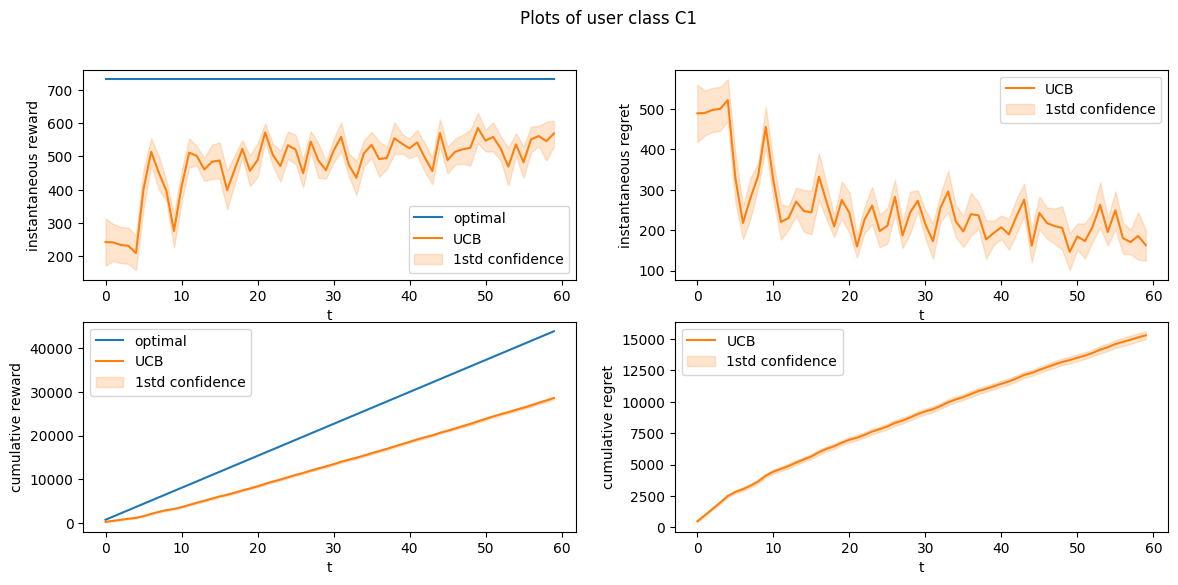

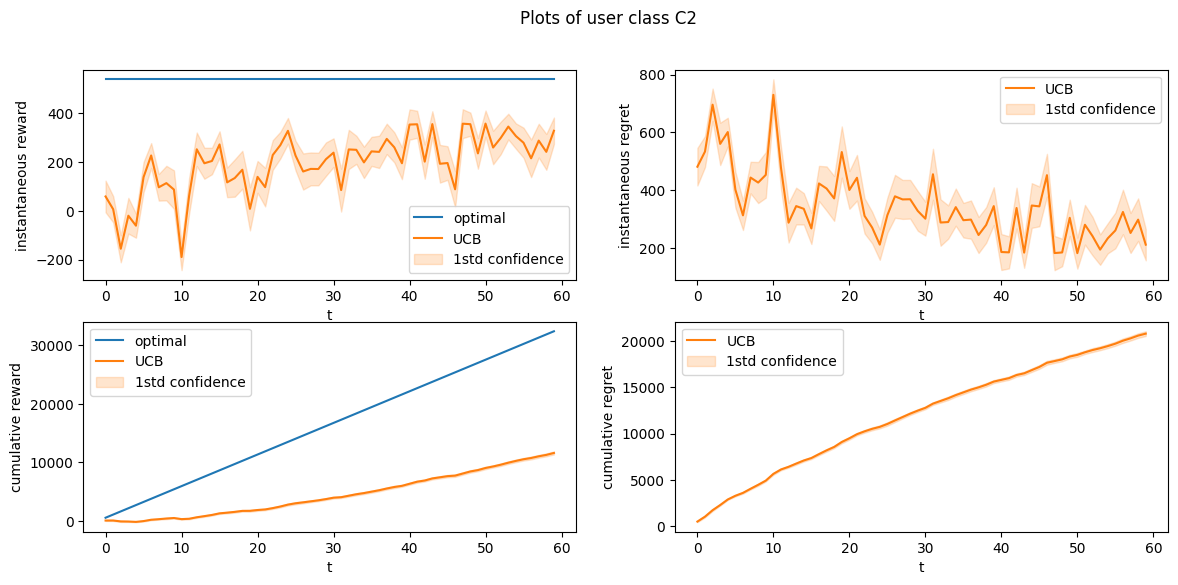

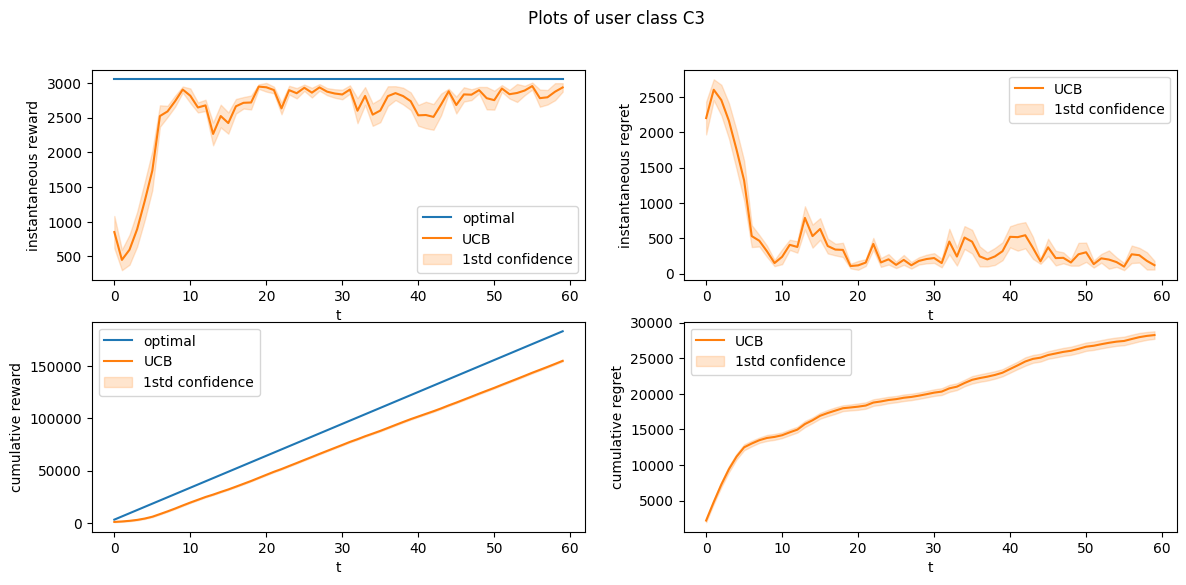

In [18]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

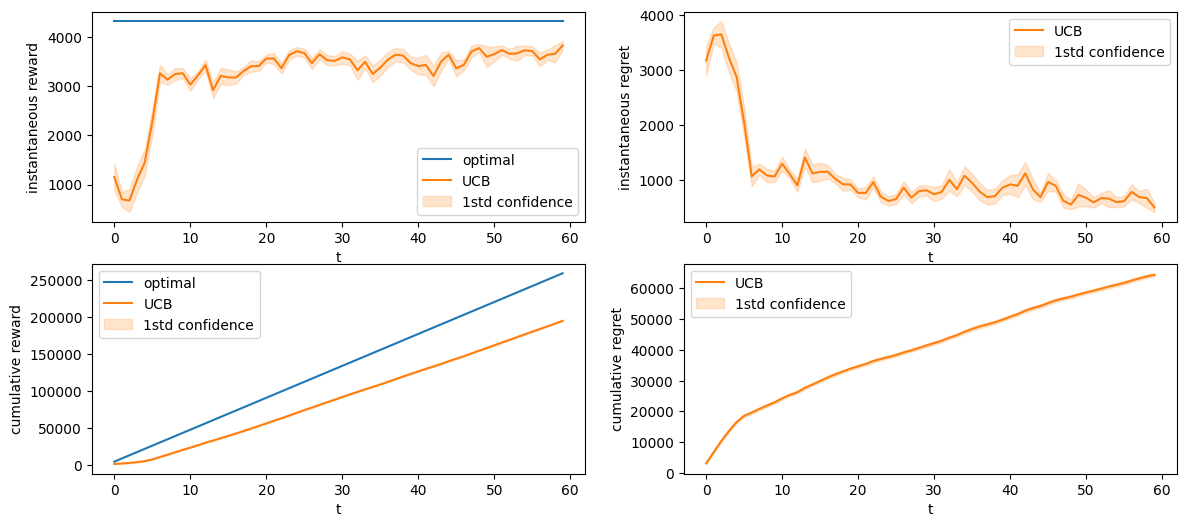

In [19]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### TS - known context structure

In [20]:
# n_experiments = 2

In [21]:
## TS learner

ts_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(BIDS, PRICES, SIGMA_CLICKS, SIGMA_COSTS, MARGIN_PARAM, user_classes)
    ts_learner = TS_FixedContextsLearner(BIDS, PRICES, MARGIN_PARAM, real_contexts)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ts_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, converted_clicks, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ts_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward, features)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

0.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


5.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


10.0%
15.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


20.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


25.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_re

30.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-p

35.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


40.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


45.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


50.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


55.00000000000001%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

65.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site

70.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


75.0%
80.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site

85.0%
90.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


95.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Plot

In [22]:
rewards_simulations = np.array(ts_rewards_per_experiment)

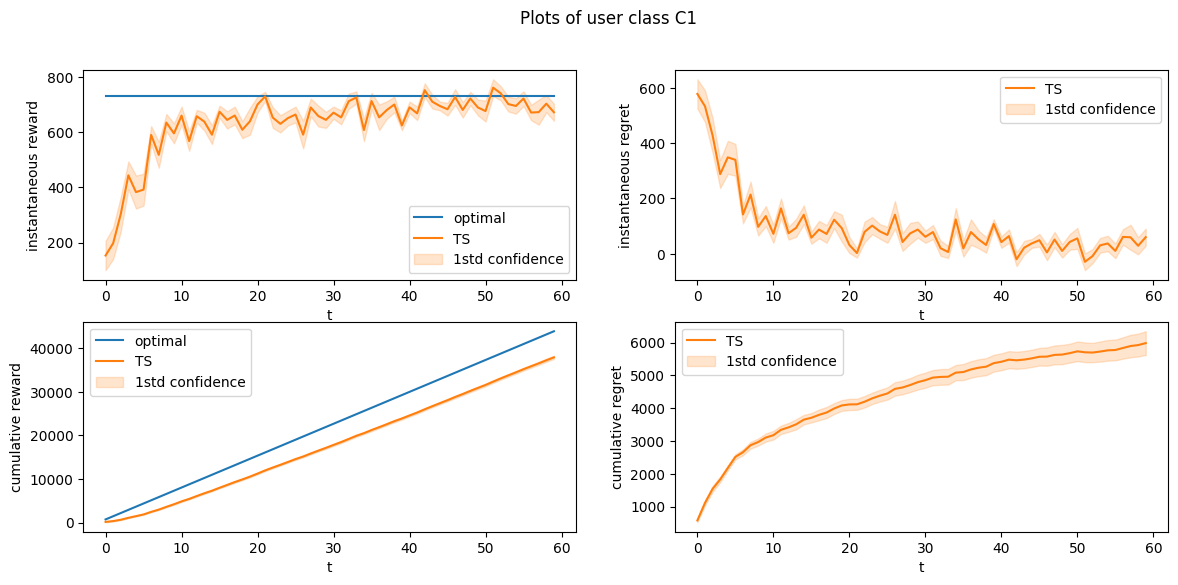

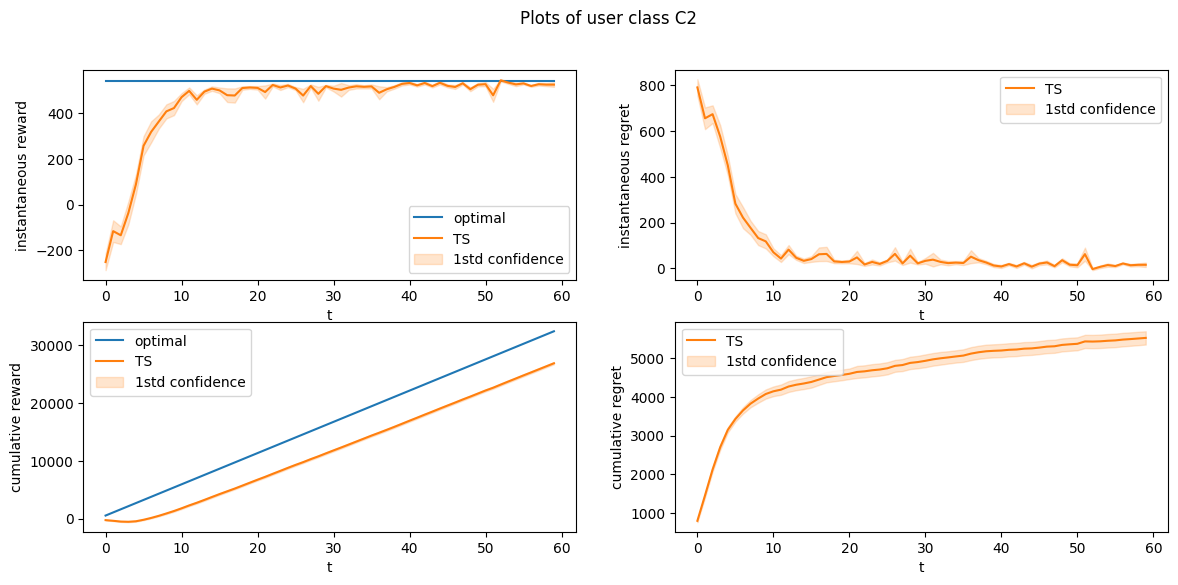

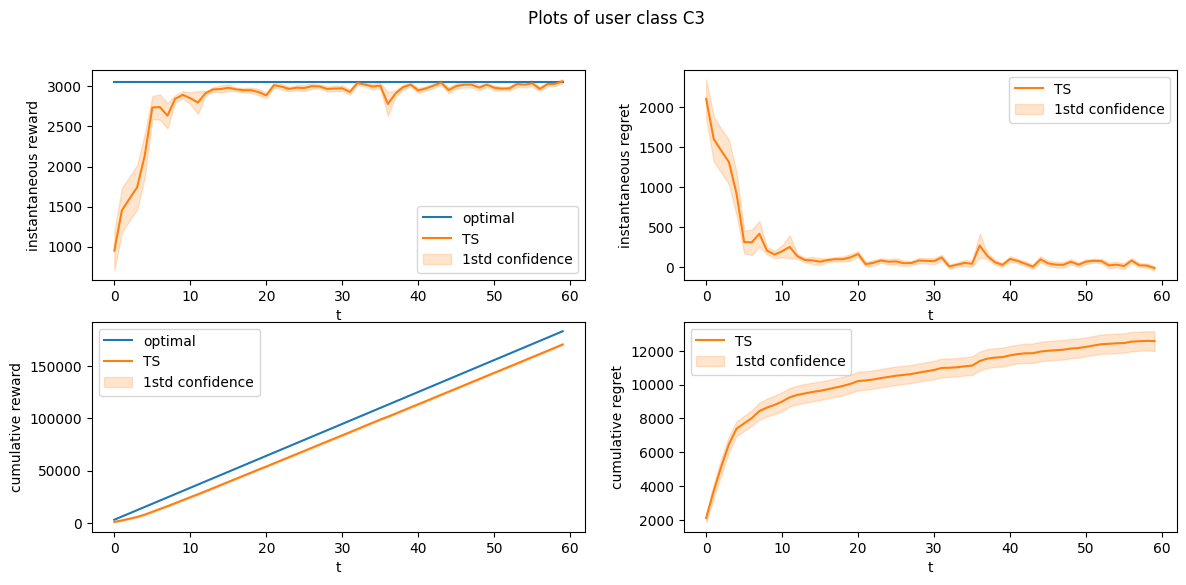

In [23]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

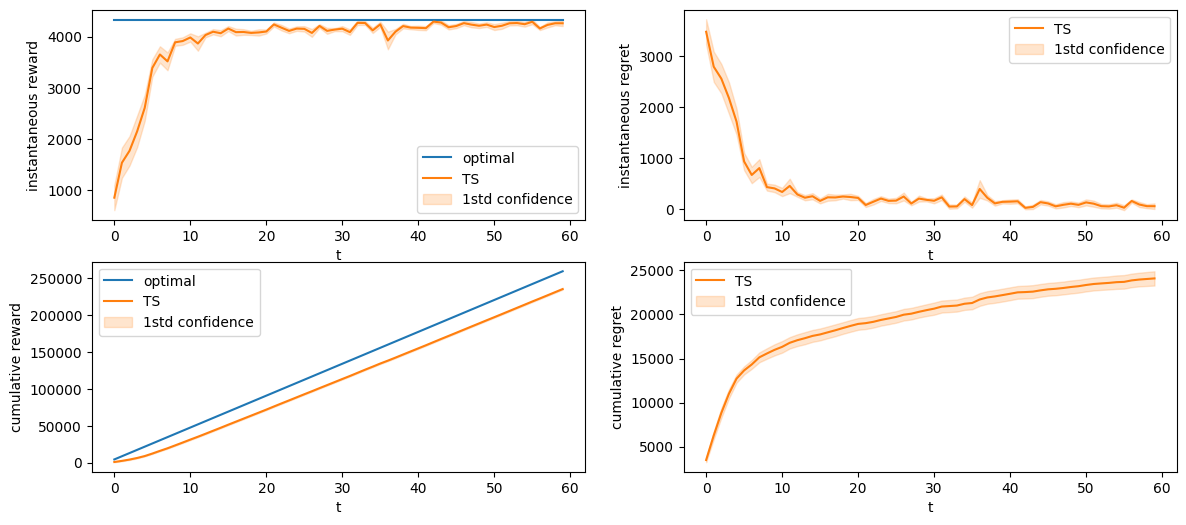

In [24]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### Plot both UCB and TS

In [27]:
ucb_sum_rewards_per_experiment = np.sum(ucb_rewards_per_experiment, axis = 2)
ts_sum_rewards_per_experiment = np.sum(ts_rewards_per_experiment, axis = 2)

## UCB
ucb_std_inst = np.std(ucb_sum_rewards_per_experiment, axis = 0) / np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(ucb_sum_rewards_per_experiment, axis = 1), axis = 0) / np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(ucb_sum_rewards_per_experiment, axis = 0)

## TS
ts_std_inst = np.std(ts_sum_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(ts_sum_rewards_per_experiment, axis = 1), axis = 0) / np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(ts_sum_rewards_per_experiment, axis = 0)

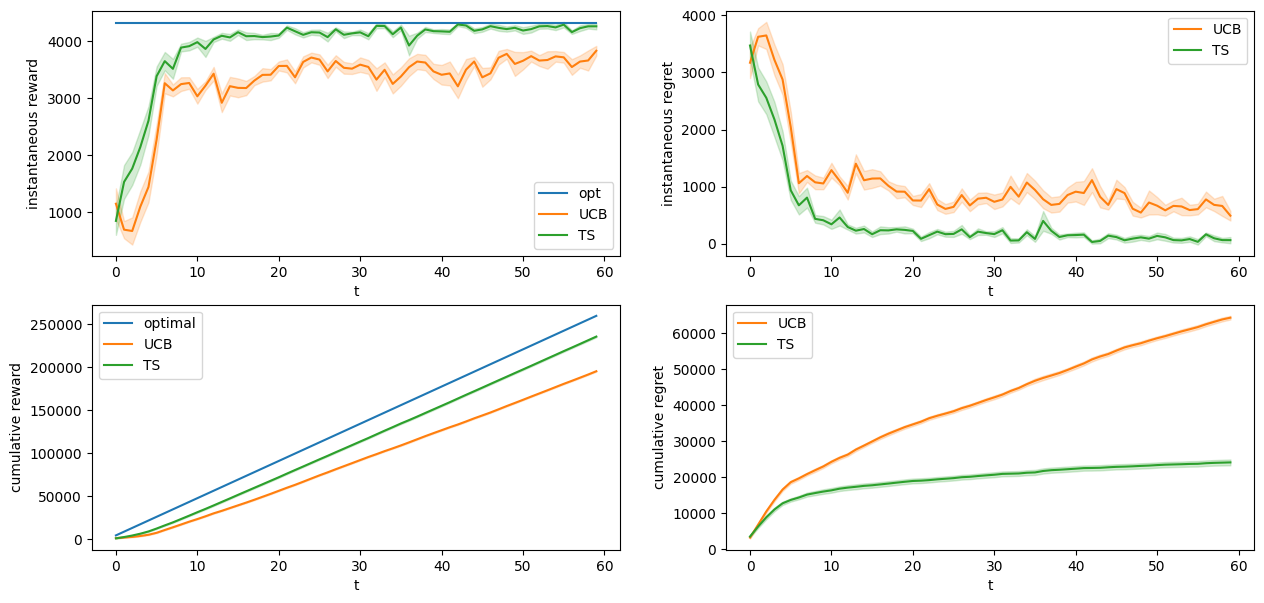

In [28]:
#Starting plots
plt.figure(figsize = (15,7))

#Comparing instantaneous reward
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "UCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "TS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing instantaneous regret
plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "UCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "TS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative reward
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative regret
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

In [29]:
import pickle


with open('ucb_rewards_per_experiment_step4_1.pickle', 'wb') as handle:
    pickle.dump(ucb_rewards_per_experiment, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('ts_rewards_per_experiment_step4_1.pickle', 'wb') as handle:
    pickle.dump(ts_rewards_per_experiment, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Case: unknown structure & no context generation

### UCB - known context structure

In [30]:
## UCB learner

ucb_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(BIDS, PRICES, SIGMA_CLICKS, SIGMA_COSTS, MARGIN_PARAM, user_classes)
    ucb_learner = UCB_FixedContextsLearner(BIDS, PRICES, MARGIN_PARAM, [ [(0,0),(0,1),(1,0),(1,1)] ], M)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, converted_clicks, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ucb_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward, features)

    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

0.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


5.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\si

10.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


15.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


20.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


25.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\si

30.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


35.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\si

40.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_re

45.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


50.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


55.00000000000001%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


65.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


70.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site

75.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


80.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


85.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


90.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


95.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Plot

In [31]:
rewards_simulations = np.array(ucb_rewards_per_experiment)

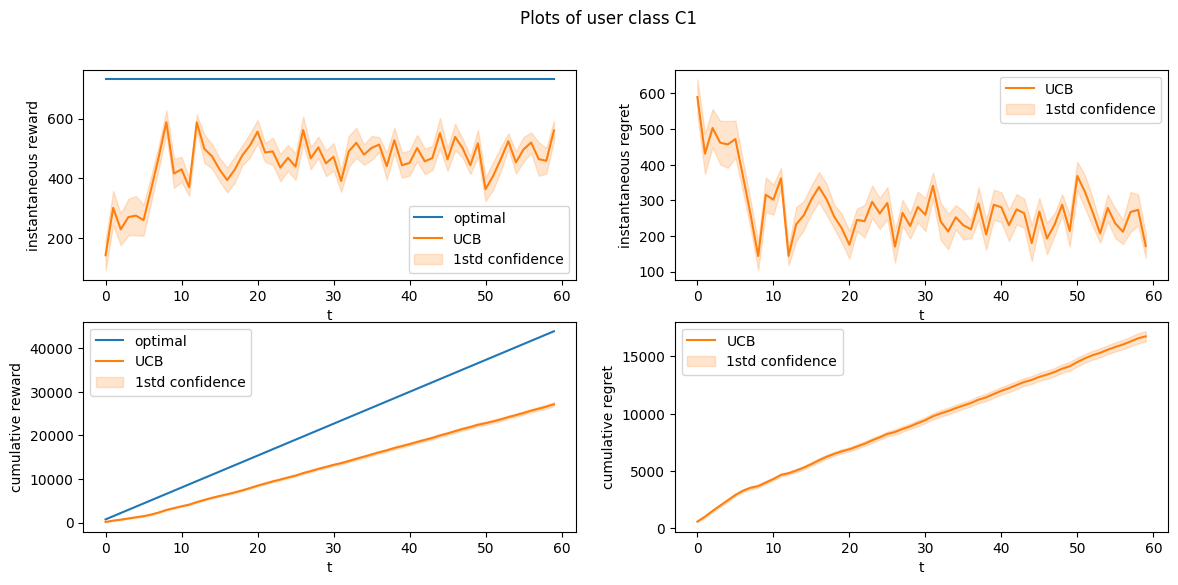

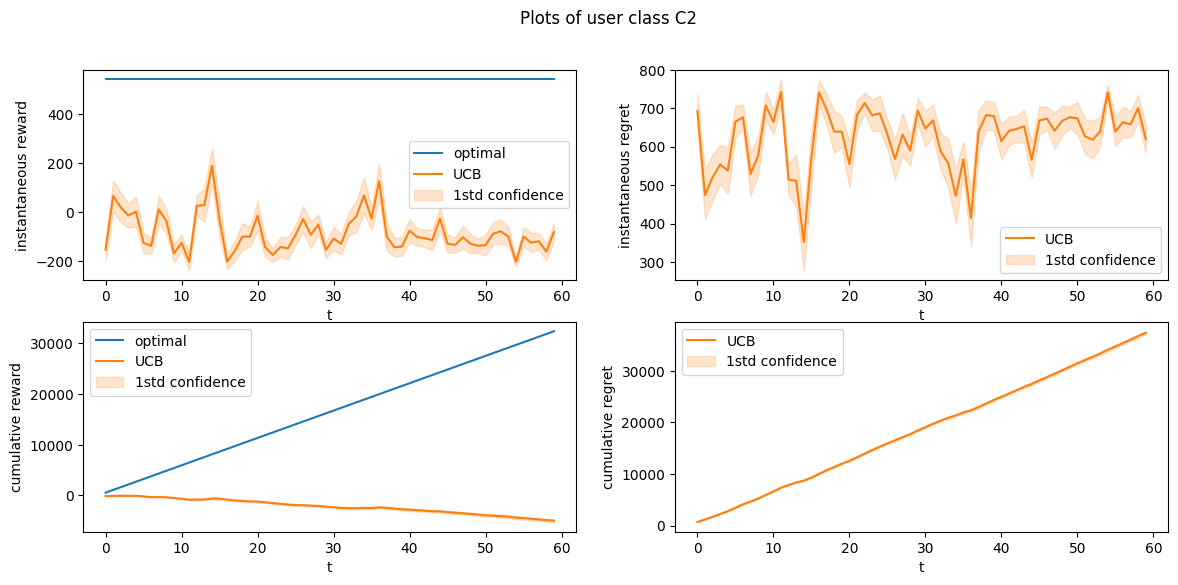

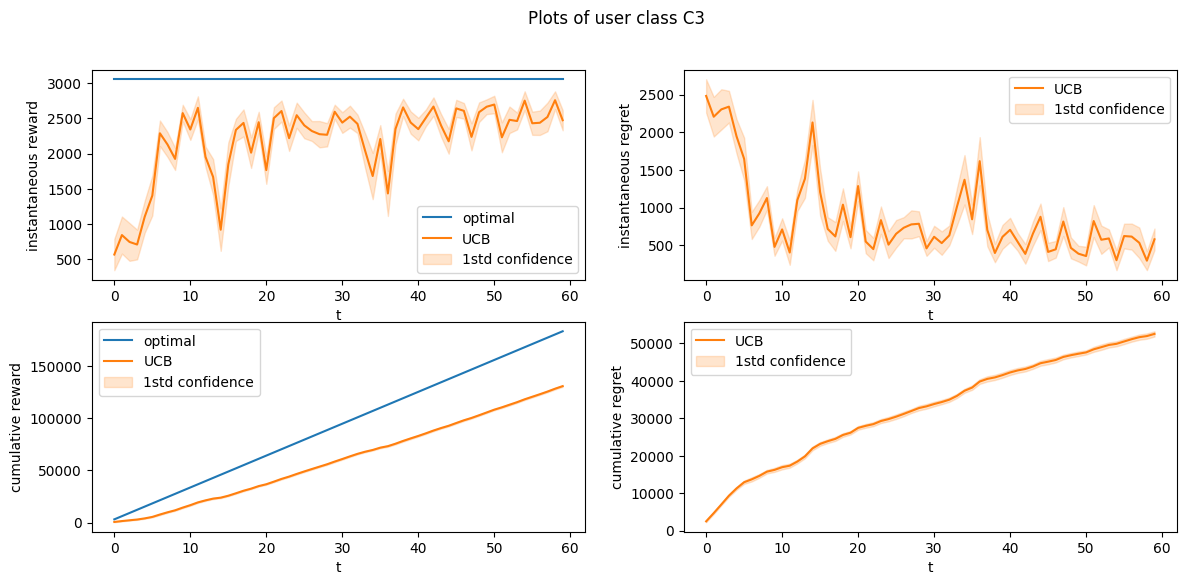

In [32]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

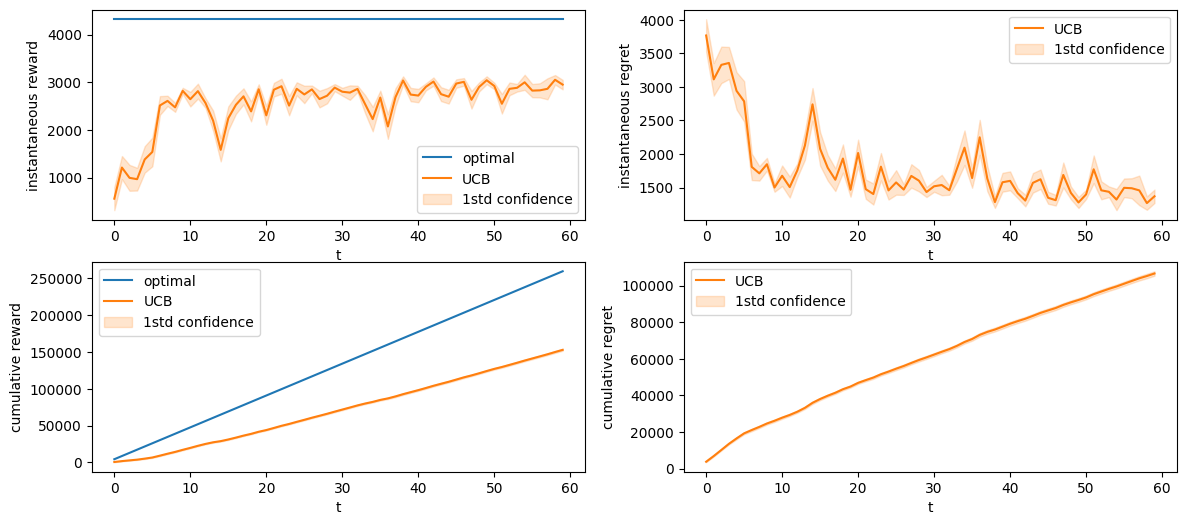

In [33]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### TS - known context structure

In [34]:
# n_experiments = 2

In [35]:
## TS learner

ts_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(BIDS, PRICES, SIGMA_CLICKS, SIGMA_COSTS, MARGIN_PARAM, user_classes)
    ts_learner = TS_FixedContextsLearner(BIDS, PRICES, MARGIN_PARAM, real_contexts)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ts_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, converted_clicks, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ts_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward, features)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

0.0%
5.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


10.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


15.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


20.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


25.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


30.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


35.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


40.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


45.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


50.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-

55.00000000000001%
60.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


65.0%
70.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


75.0%
80.0%
85.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


90.0%
95.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Plot

In [36]:
rewards_simulations = np.array(ts_rewards_per_experiment)

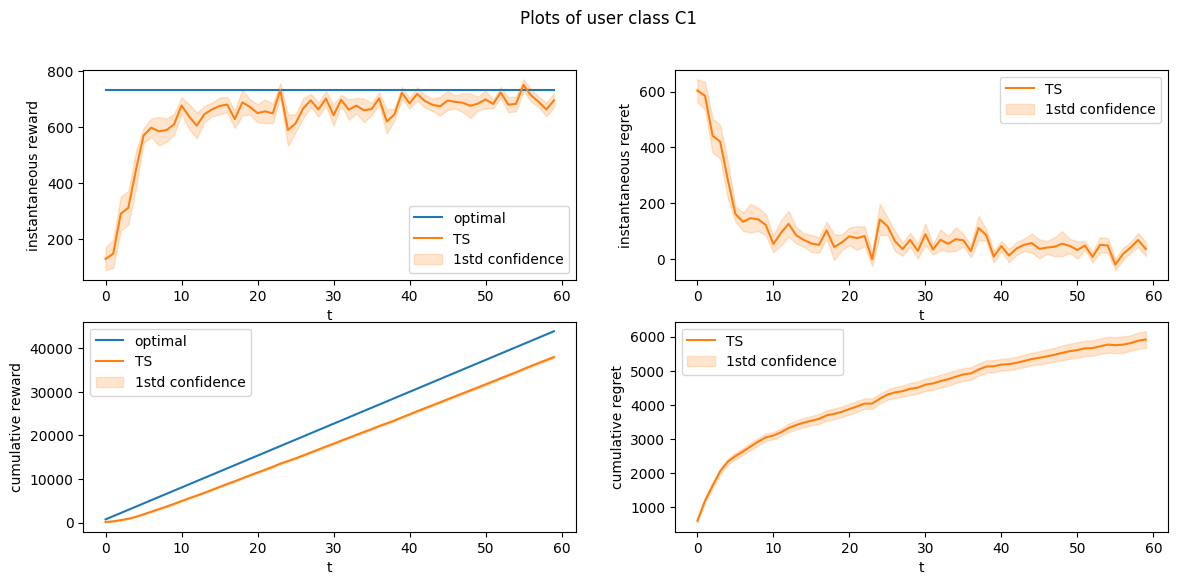

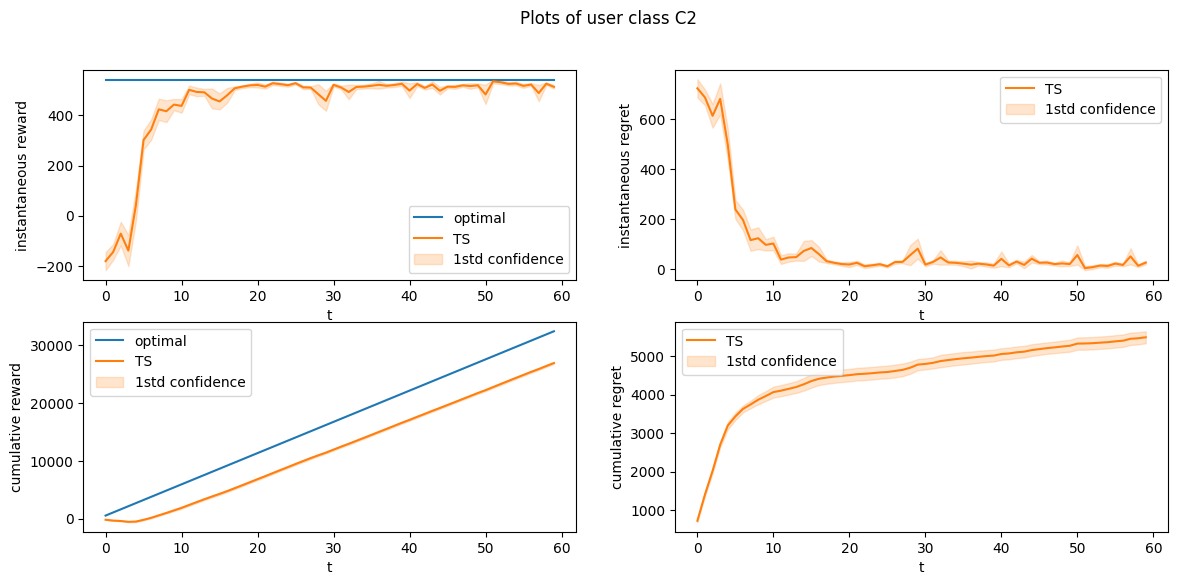

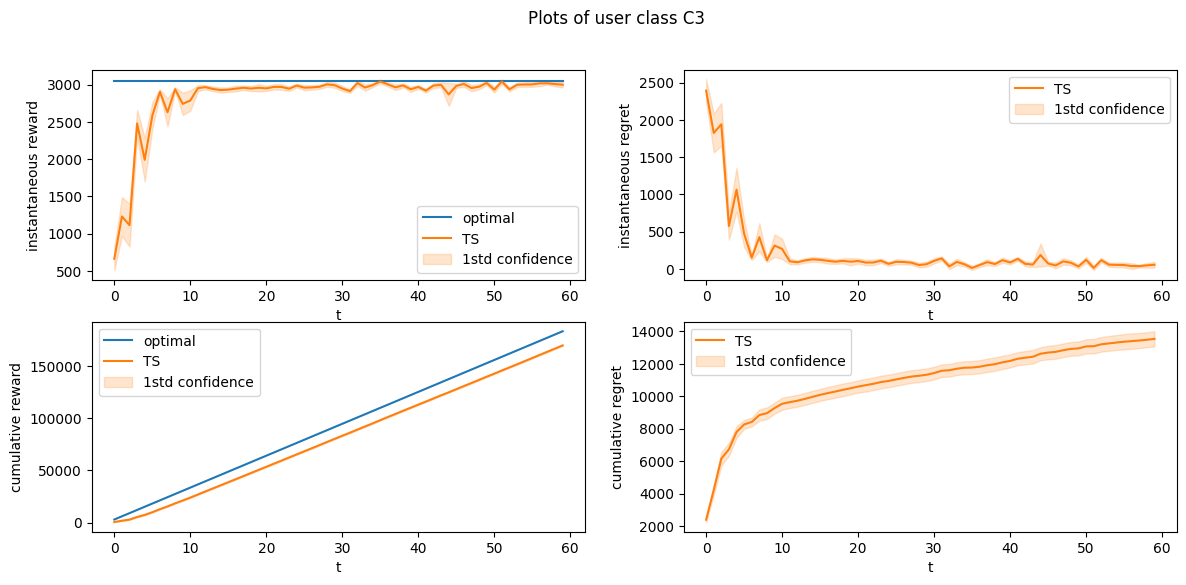

In [37]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

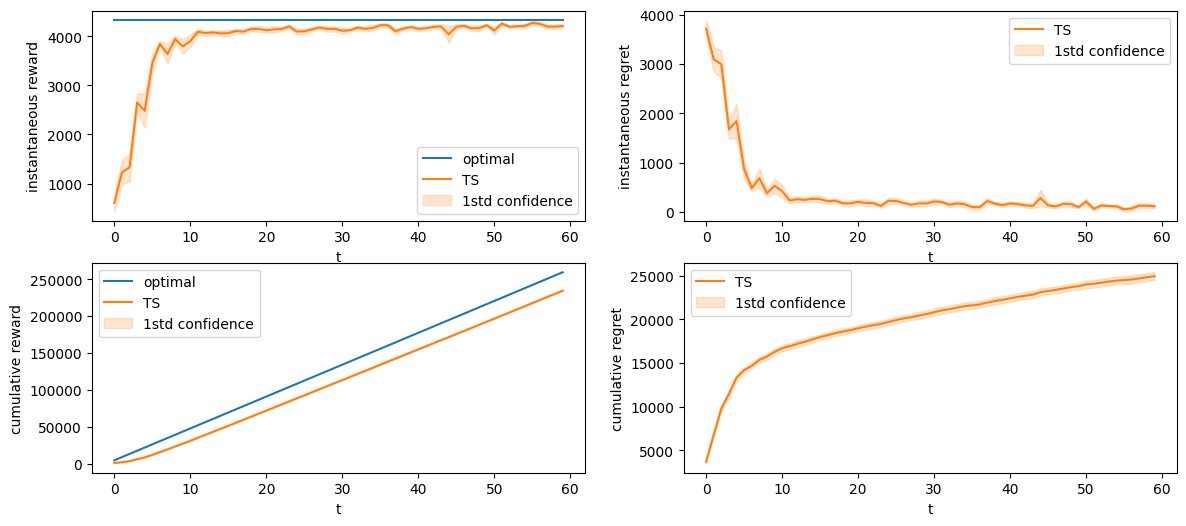

In [38]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### Plot both UCB and TS

In [39]:
## UCB
ucb_sum_rewards_per_experiment = np.sum(ucb_rewards_per_experiment, axis = 2)
ts_sum_rewards_per_experiment = np.sum(ts_rewards_per_experiment, axis = 2)

## UCB
ucb_std_inst = np.std(ucb_sum_rewards_per_experiment, axis = 0) / np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(ucb_sum_rewards_per_experiment, axis = 1), axis = 0) / np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(ucb_sum_rewards_per_experiment, axis = 0)

## TS
ts_std_inst = np.std(ts_sum_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(ts_sum_rewards_per_experiment, axis = 1), axis = 0) / np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(ts_sum_rewards_per_experiment, axis = 0)

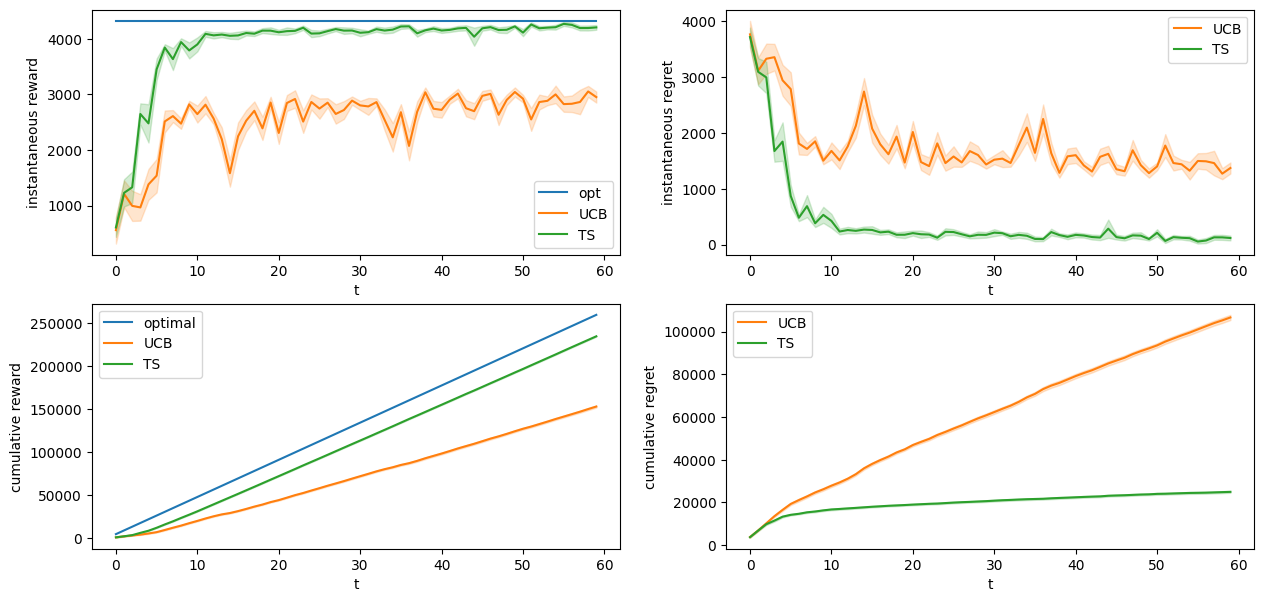

In [40]:
#Starting plots
plt.figure(figsize = (15,7))

#Comparing instantaneous reward
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "UCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "TS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing instantaneous regret
plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "UCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "TS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative reward
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative regret
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

In [41]:
import pickle


with open('ucb_rewards_per_experiment_step4_2.pickle', 'wb') as handle:
    pickle.dump(ucb_rewards_per_experiment, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('ts_rewards_per_experiment_step4_2.pickle', 'wb') as handle:
    pickle.dump(ts_rewards_per_experiment, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Case: unknown structure & with context generation

### UCB - known context structure

In [42]:
## UCB learner

ucb_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(BIDS, PRICES, SIGMA_CLICKS, SIGMA_COSTS, MARGIN_PARAM, user_classes)
    ucb_learner = UCB_ContextsGreadyLearner(BIDS, PRICES, MARGIN_PARAM, window_context, M)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, converted_clicks, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ucb_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward, features)

    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

0.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site

evaluating change at time 14
  current lb reward =  5524.37882661895
  candidate partition lb reward =  131339.37259284343
PARTITION CHANGED AT TIME 14
  current lb reward =  131339.37259284343
  candidate partition lb reward =  89327.98696703842
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  150127.46676691686
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


5.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site

evaluating change at time 14
  current lb reward =  57975.131823647294
  candidate partition lb reward =  137396.93861342323
PARTITION CHANGED AT TIME 14
  current lb reward =  137396.93861342323
  candidate partition lb reward =  90244.60865410748
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  153112.7596964896
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


10.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  20278.87901835532
  candidate partition lb reward =  136583.30250720517
PARTITION CHANGED AT TIME 14
  current lb reward =  136583.30250720517
  candidate partition lb reward =  89743.96265096309
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  141595.81003056004
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


15.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  40383.15278535842
  candidate partition lb reward =  136657.83846742945
PARTITION CHANGED AT TIME 14
  current lb reward =  136657.83846742945
  candidate partition lb reward =  90273.85936180607
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  148818.99378462756
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


20.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site

evaluating change at time 14
  current lb reward =  58934.836051885795
  candidate partition lb reward =  144087.18097158134
PARTITION CHANGED AT TIME 14
  current lb reward =  144087.18097158134
  candidate partition lb reward =  93252.47177069446
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  156930.49923648871
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


25.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  5579.792596235944
  candidate partition lb reward =  138603.97009170556
PARTITION CHANGED AT TIME 14
  current lb reward =  138603.97009170556
  candidate partition lb reward =  89355.05734247016
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  142264.53968294623
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


30.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  5776.8432703440485
  candidate partition lb reward =  145597.29021042943
PARTITION CHANGED AT TIME 14
  current lb reward =  145597.29021042943
  candidate partition lb reward =  92744.39680261855
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  84373.77343606835
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


35.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  37769.44757760298
  candidate partition lb reward =  134651.99730629977
PARTITION CHANGED AT TIME 14
  current lb reward =  134651.99730629977
  candidate partition lb reward =  90066.05875136096
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  145286.63018467053
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


40.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  5923.377448753422
  candidate partition lb reward =  61136.25659129352
PARTITION CHANGED AT TIME 14
  current lb reward =  61136.25659129352
  candidate partition lb reward =  83273.27088338464
PARTITION CHANGED AT TIME 14
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  13042.9976436187
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


45.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  35859.53167420335
  candidate partition lb reward =  140133.02415412152
PARTITION CHANGED AT TIME 14
  current lb reward =  140133.02415412152
  candidate partition lb reward =  90218.6774462253
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  143137.15581436586
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


50.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  5722.43381814711
  candidate partition lb reward =  137608.66961737597
PARTITION CHANGED AT TIME 14
  current lb reward =  137608.66961737597
  candidate partition lb reward =  87757.98974316163
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  97660.40011967474
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


55.00000000000001%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  5875.261678677966
  candidate partition lb reward =  134186.05796685765
PARTITION CHANGED AT TIME 14
  current lb reward =  134186.05796685765
  candidate partition lb reward =  90195.16064797623
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  86692.30963480347
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


60.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  6072.721289366481
  candidate partition lb reward =  145355.73551566806
PARTITION CHANGED AT TIME 14
  current lb reward =  145355.73551566806
  candidate partition lb reward =  94563.29813968175
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  154042.2875672861
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


65.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  56307.322270165976
  candidate partition lb reward =  137552.5400704723
PARTITION CHANGED AT TIME 14
  current lb reward =  137552.5400704723
  candidate partition lb reward =  88852.71948114538
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  152867.75069029143
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


70.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  57514.2901480002
  candidate partition lb reward =  140678.53008197065
PARTITION CHANGED AT TIME 14
  current lb reward =  140678.53008197065
  candidate partition lb reward =  91499.45448501062
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  142158.53977630878
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 42
evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


75.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  5812.7740891666035
  candidate partition lb reward =  140903.4887708842
PARTITION CHANGED AT TIME 14
  current lb reward =  140903.4887708842
  candidate partition lb reward =  87840.34188621669
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  151192.43499354244
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


80.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  22906.992306144613
  candidate partition lb reward =  144165.76010108468
PARTITION CHANGED AT TIME 14
  current lb reward =  144165.76010108468
  candidate partition lb reward =  91053.89733263431
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  95011.87501962602
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


85.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  38301.0054473954
  candidate partition lb reward =  130430.18516656061
PARTITION CHANGED AT TIME 14
  current lb reward =  130430.18516656061
  candidate partition lb reward =  80806.29883142759
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  150190.17290506346
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


90.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  55881.87761070675
  candidate partition lb reward =  132689.99447434192
PARTITION CHANGED AT TIME 14
  current lb reward =  132689.99447434192
  candidate partition lb reward =  88736.72578738305
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  84989.96909382752
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


95.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  58182.90269186696
  candidate partition lb reward =  140756.7288505289
PARTITION CHANGED AT TIME 14
  current lb reward =  140756.7288505289
  candidate partition lb reward =  89045.71367779853
evaluating change at time 28


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


  current lb reward =  150507.6563591926
  candidate partition lb reward =  inf
PARTITION CHANGED AT TIME 28
evaluating change at time 42


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


evaluating change at time 56


C:\Users\oswal\AppData\Local\Temp\ipykernel_18040\2459667418.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))


Plot

In [43]:
rewards_simulations = np.array(ucb_rewards_per_experiment)

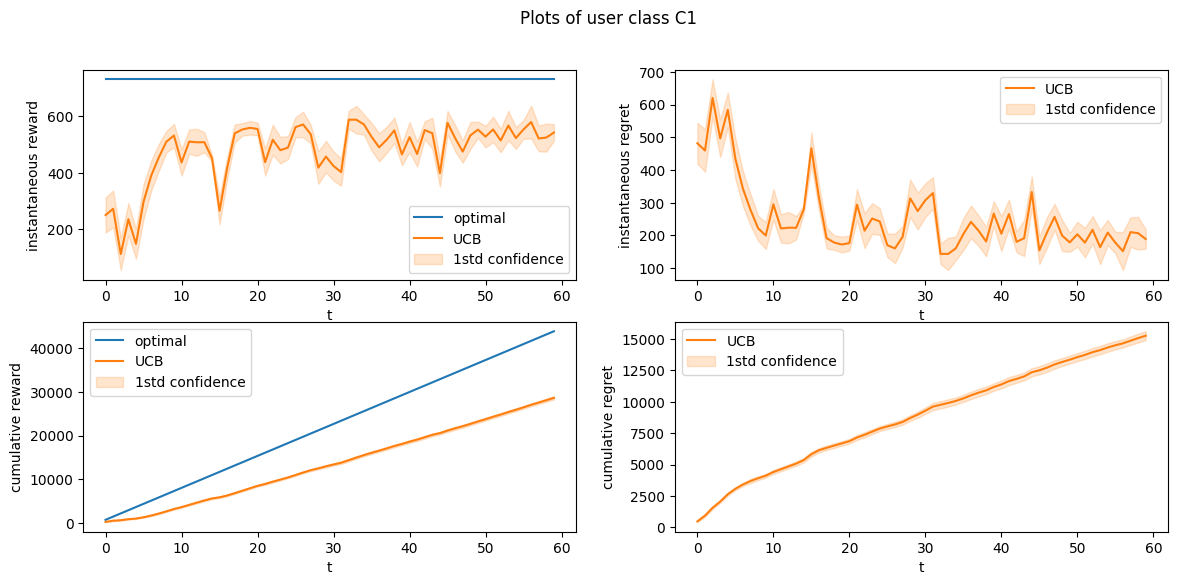

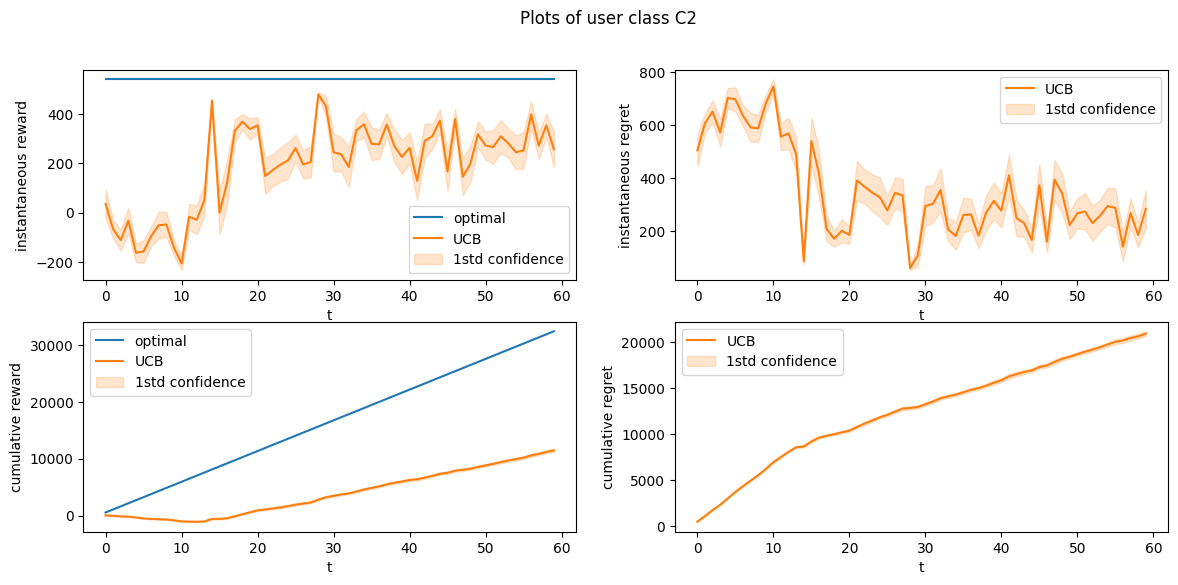

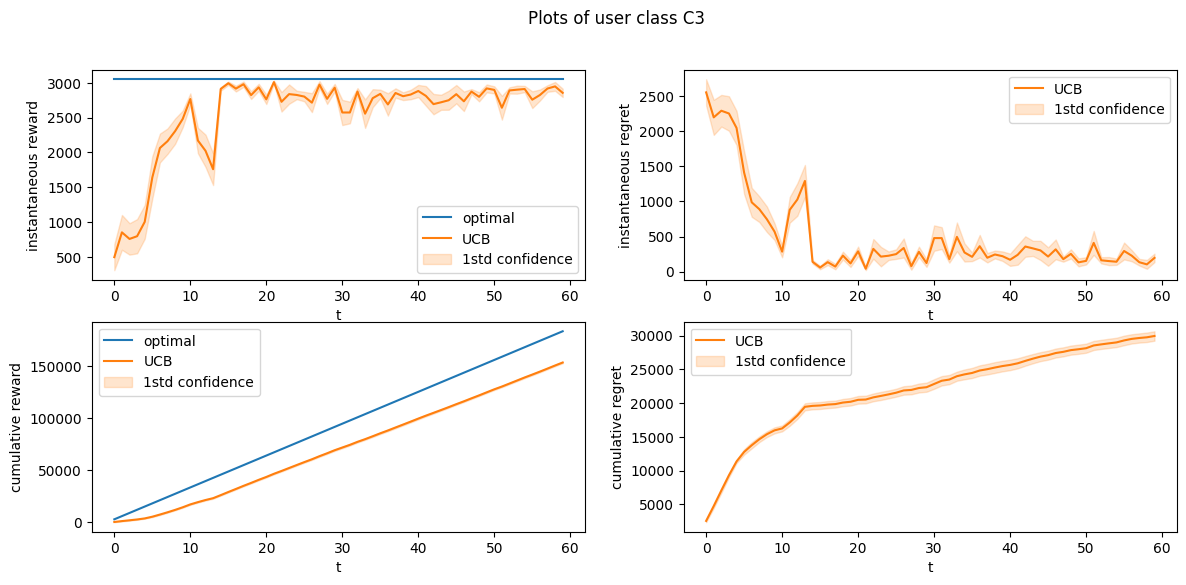

In [44]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

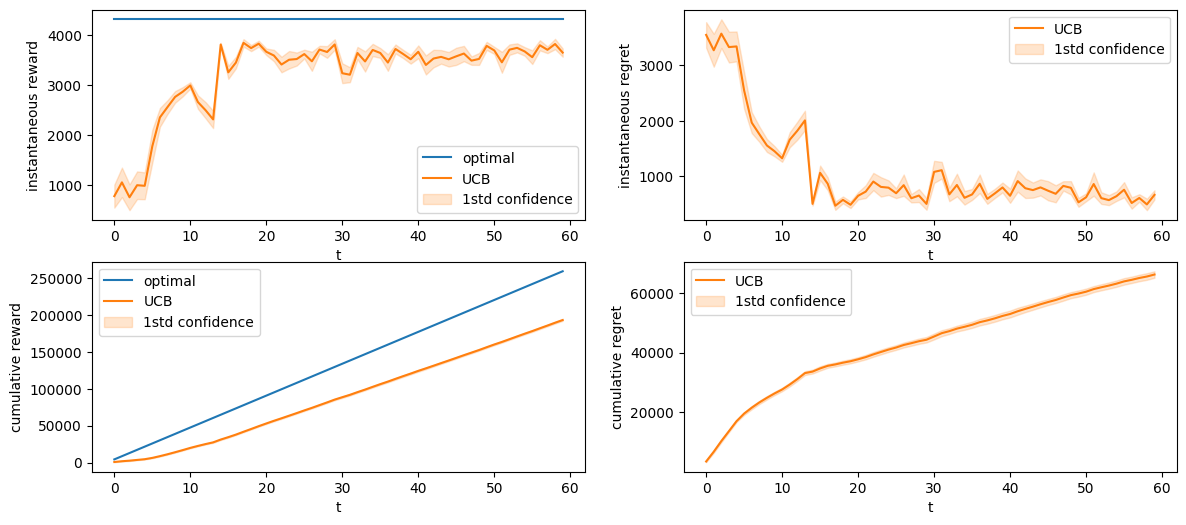

In [45]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### TS - known context structure

In [46]:
# n_experiments = 2

In [47]:
## TS learner

ts_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(BIDS, PRICES, SIGMA_CLICKS, SIGMA_COSTS, MARGIN_PARAM, user_classes)
    ts_learner = TS_ContextsGreedyLearner(BIDS, PRICES, MARGIN_PARAM, window_context)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ts_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, converted_clicks, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ts_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward, features)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

0.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\si

evaluating change at time 14
  current lb reward =  1061.3522028846746
  candidate partition lb reward =  2958.604468678839
PARTITION CHANGED AT TIME 14
  current lb reward =  2958.604468678839
  candidate partition lb reward =  1702.6079986894538
evaluating change at time 28
  current lb reward =  3217.7461598316136
  candidate partition lb reward =  3908.5295285378375
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56
5.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  991.1693118683279
  candidate partition lb reward =  2775.406451586088
PARTITION CHANGED AT TIME 14
  current lb reward =  2775.406451586088
  candidate partition lb reward =  1780.6534056023845
evaluating change at time 28
  current lb reward =  3405.4961698245093
  candidate partition lb reward =  3962.7807276930944
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


10.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  1049.257091365374
  candidate partition lb reward =  3344.336129427775
PARTITION CHANGED AT TIME 14
  current lb reward =  3344.336129427775
  candidate partition lb reward =  1962.9581052562082
evaluating change at time 28
  current lb reward =  3497.551951706264
  candidate partition lb reward =  4154.900592748277
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56
15.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  973.1209579559547
  candidate partition lb reward =  2964.165978281092
PARTITION CHANGED AT TIME 14
  current lb reward =  2964.165978281092
  candidate partition lb reward =  1829.6023628385344
evaluating change at time 28
  current lb reward =  3442.714556692656
  candidate partition lb reward =  4014.713973971494
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56
20.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  1029.3690553755816
  candidate partition lb reward =  3392.484851104683
PARTITION CHANGED AT TIME 14
  current lb reward =  3392.484851104683
  candidate partition lb reward =  1611.5841512402435
evaluating change at time 28
  current lb reward =  3394.325783795599
  candidate partition lb reward =  4003.9537750884497
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56
25.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\si

evaluating change at time 14
  current lb reward =  1024.6675649631616
  candidate partition lb reward =  3026.328134472901
PARTITION CHANGED AT TIME 14
  current lb reward =  3026.328134472901
  candidate partition lb reward =  1643.9866556936818
evaluating change at time 28
  current lb reward =  3444.859411390589
  candidate partition lb reward =  3817.434317853963
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56
30.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  1051.6927302332672
  candidate partition lb reward =  3233.8542571613607
PARTITION CHANGED AT TIME 14
  current lb reward =  3233.8542571613607
  candidate partition lb reward =  1647.5648271286723
evaluating change at time 28
  current lb reward =  3383.9801551345563
  candidate partition lb reward =  3687.4272489756945
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56
35.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  979.0148124765375
  candidate partition lb reward =  3290.1741657628204
PARTITION CHANGED AT TIME 14
  current lb reward =  3290.1741657628204
  candidate partition lb reward =  1884.0864633029103
evaluating change at time 28
  current lb reward =  3220.926779708981
  candidate partition lb reward =  3980.247471931833
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56
40.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  1034.3887011813545
  candidate partition lb reward =  3097.0423529301615
PARTITION CHANGED AT TIME 14
  current lb reward =  3097.0423529301615
  candidate partition lb reward =  1926.8490662069696
evaluating change at time 28
  current lb reward =  2731.7054888521257
  candidate partition lb reward =  4078.0883442741597
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56
45.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site

evaluating change at time 14
  current lb reward =  975.8725570146765
  candidate partition lb reward =  3103.3079692516762
PARTITION CHANGED AT TIME 14
  current lb reward =  3103.3079692516762
  candidate partition lb reward =  1911.8761541456952
evaluating change at time 28
  current lb reward =  3446.117663270235
  candidate partition lb reward =  3898.8976868981254
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56
50.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  1020.3778920386454
  candidate partition lb reward =  2939.5671723183214
PARTITION CHANGED AT TIME 14
  current lb reward =  2939.5671723183214
  candidate partition lb reward =  1492.7385964451755
evaluating change at time 28
  current lb reward =  3452.8866082289314
  candidate partition lb reward =  4071.5083458227477
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56
55.00000000000001%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  924.9329871571774
  candidate partition lb reward =  2928.2324195855363
PARTITION CHANGED AT TIME 14
  current lb reward =  2928.2324195855363
  candidate partition lb reward =  1566.934795692111
evaluating change at time 28
  current lb reward =  3130.06562191382
  candidate partition lb reward =  3412.313241838506
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56
60.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  983.6948540631395
  candidate partition lb reward =  3355.723746789302
PARTITION CHANGED AT TIME 14
  current lb reward =  3355.723746789302
  candidate partition lb reward =  1775.3230594383494
evaluating change at time 28
  current lb reward =  3475.558849739666
  candidate partition lb reward =  4035.6770875595125
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56
65.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  1009.08802259366
  candidate partition lb reward =  3316.9714432674295
PARTITION CHANGED AT TIME 14
  current lb reward =  3316.9714432674295
  candidate partition lb reward =  1749.0571327407665
evaluating change at time 28
  current lb reward =  3356.554159836124
  candidate partition lb reward =  3973.3642265759654
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56
70.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  929.226070573951
  candidate partition lb reward =  2830.9484569349925
PARTITION CHANGED AT TIME 14
  current lb reward =  2830.9484569349925
  candidate partition lb reward =  1820.446680014154
evaluating change at time 28
  current lb reward =  3404.8924321313552
  candidate partition lb reward =  3627.6921296553674
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56
75.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  1047.8036971386514
  candidate partition lb reward =  3249.682866042106
PARTITION CHANGED AT TIME 14
  current lb reward =  3249.682866042106
  candidate partition lb reward =  1644.2759117241706
evaluating change at time 28
  current lb reward =  3452.4424599068325
  candidate partition lb reward =  3867.1488621893022
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56
80.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  1044.1177802518284
  candidate partition lb reward =  2201.564799993555
PARTITION CHANGED AT TIME 14
  current lb reward =  2201.564799993555
  candidate partition lb reward =  1973.7461009852748
evaluating change at time 28
  current lb reward =  3356.953281790272
  candidate partition lb reward =  3944.6682904871673
PARTITION CHANGED AT TIME 28
evaluating change at time 42


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


evaluating change at time 56
85.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  980.2629737334607
  candidate partition lb reward =  2779.973233999622
PARTITION CHANGED AT TIME 14
  current lb reward =  2779.973233999622
  candidate partition lb reward =  1854.5239836718454
evaluating change at time 28
  current lb reward =  3428.6689028585197
  candidate partition lb reward =  4073.750506389106
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56
90.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  948.3911946251596
  candidate partition lb reward =  3063.265730929402
PARTITION CHANGED AT TIME 14
  current lb reward =  3063.265730929402
  candidate partition lb reward =  1571.9329016809236
evaluating change at time 28
  current lb reward =  3378.4971967836645
  candidate partition lb reward =  3951.9328488447545
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56
95.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


evaluating change at time 14
  current lb reward =  907.8356733149745
  candidate partition lb reward =  3348.5068515915164
PARTITION CHANGED AT TIME 14
  current lb reward =  3348.5068515915164
  candidate partition lb reward =  1787.408867670079
evaluating change at time 28
  current lb reward =  3453.7060809108316
  candidate partition lb reward =  4158.302977601592
PARTITION CHANGED AT TIME 28
evaluating change at time 42
evaluating change at time 56


Plot

In [48]:
rewards_simulations = np.array(ts_rewards_per_experiment)

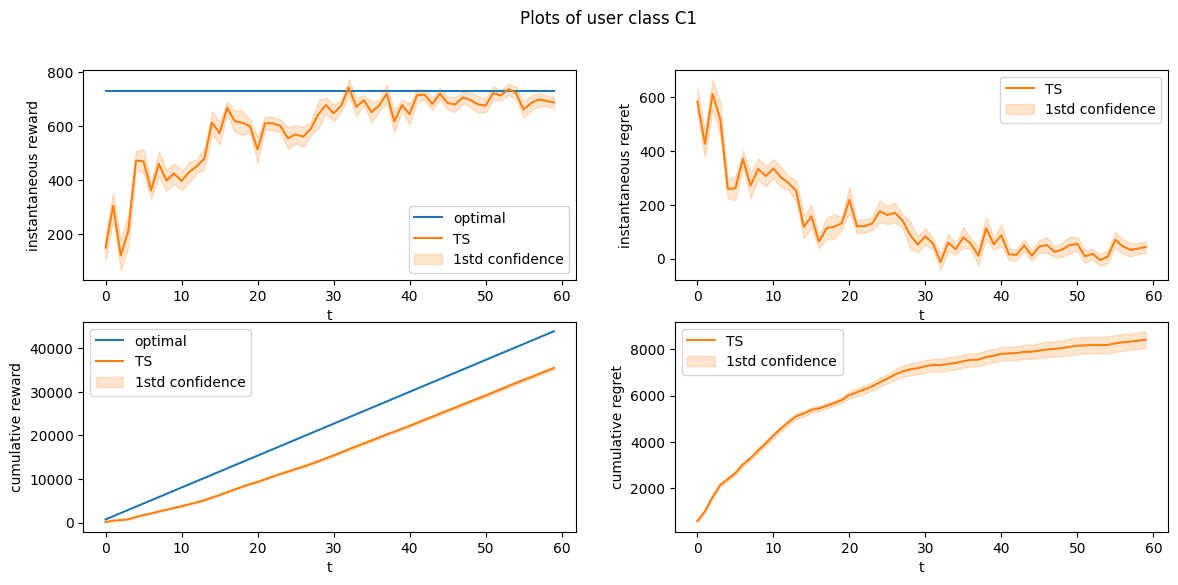

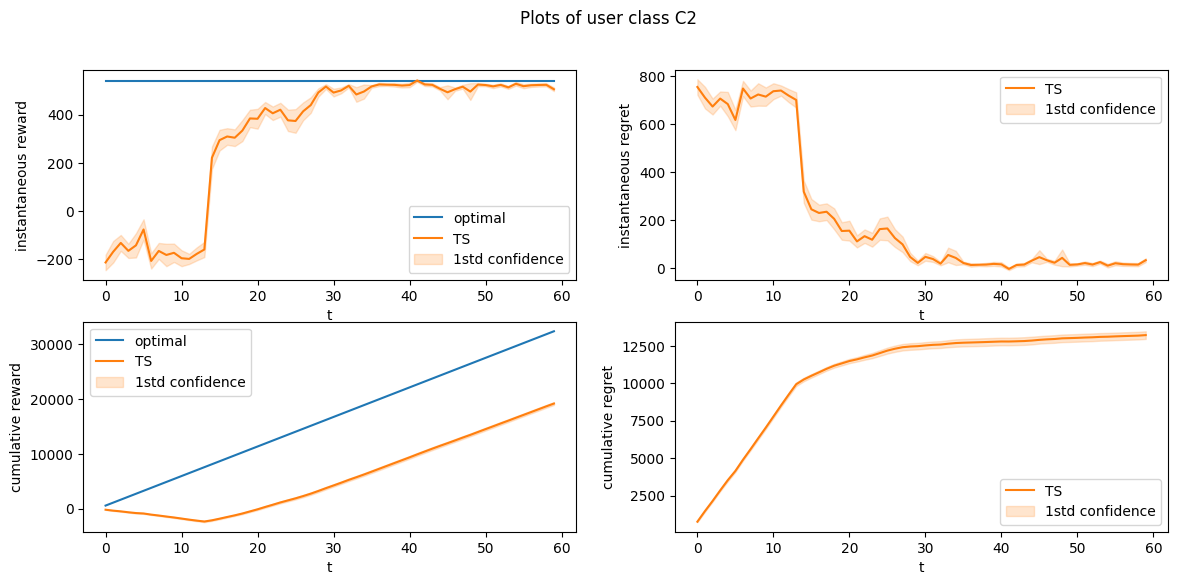

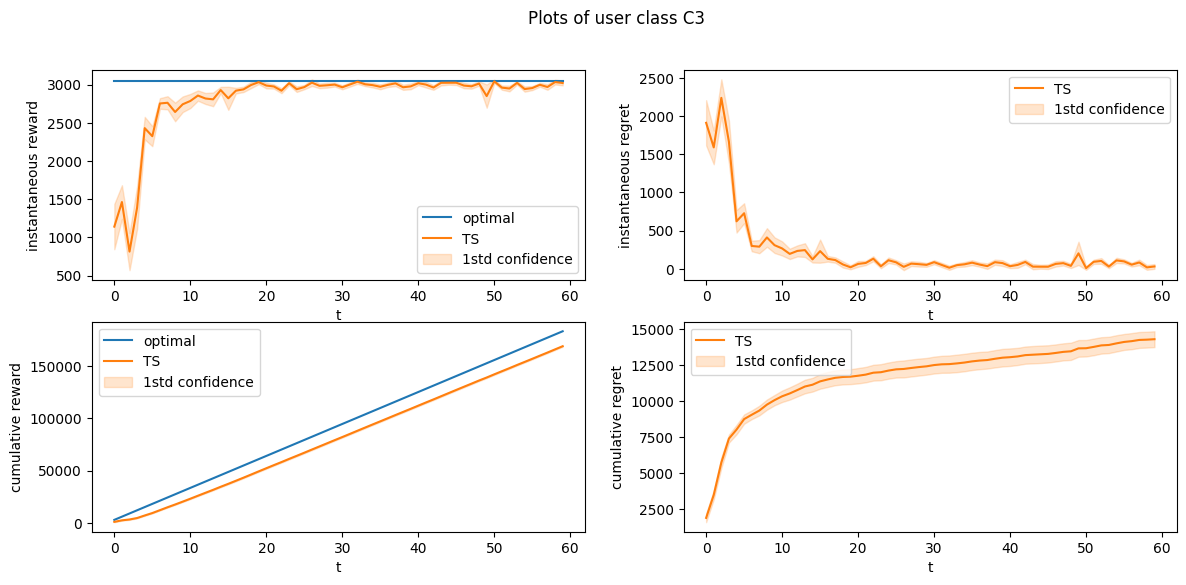

In [49]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

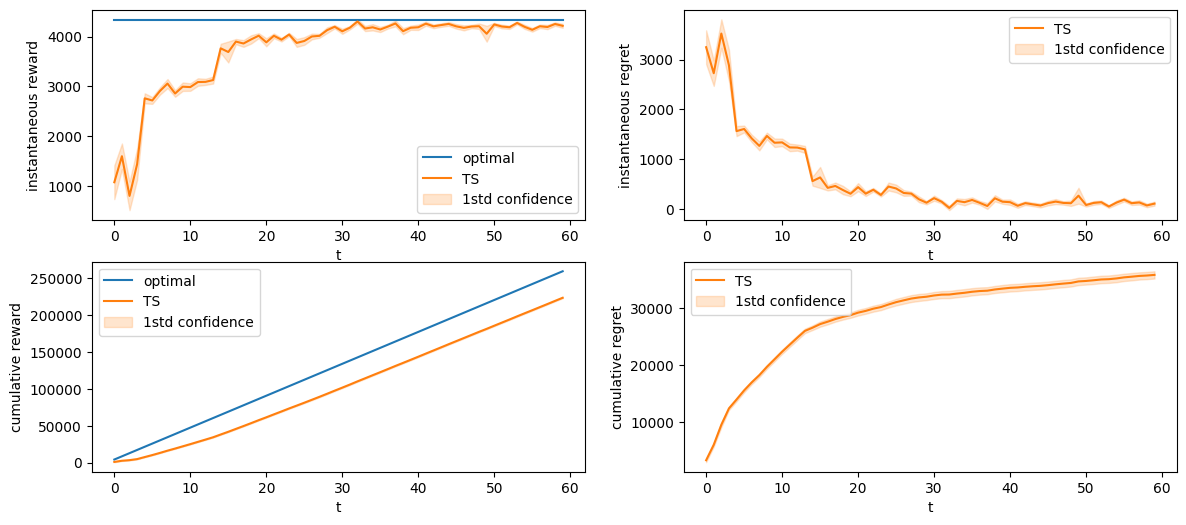

In [50]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### Plot both UCB and TS

In [51]:
ucb_sum_rewards_per_experiment = np.sum(ucb_rewards_per_experiment, axis = 2)
ts_sum_rewards_per_experiment = np.sum(ts_rewards_per_experiment, axis = 2)

## UCB
ucb_std_inst = np.std(ucb_sum_rewards_per_experiment, axis = 0) / np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(ucb_sum_rewards_per_experiment, axis = 1), axis = 0) / np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(ucb_sum_rewards_per_experiment, axis = 0)

## TS
ts_std_inst = np.std(ts_sum_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(ts_sum_rewards_per_experiment, axis = 1), axis = 0) / np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(ts_sum_rewards_per_experiment, axis = 0)

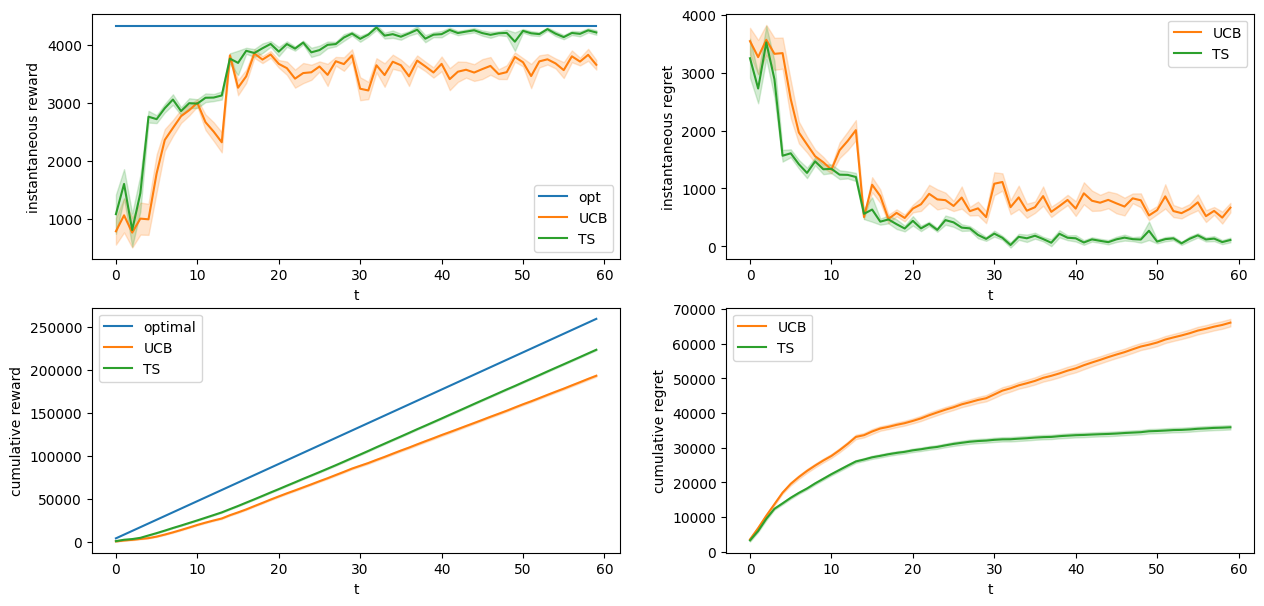

In [52]:
#Starting plots
plt.figure(figsize = (15,7))

#Comparing instantaneous reward
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "UCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "TS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing instantaneous regret
plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "UCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "TS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative reward
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative regret
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

In [53]:
import pickle


with open('ucb_rewards_per_experiment_step4_3.pickle', 'wb') as handle:
    pickle.dump(ucb_rewards_per_experiment, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('ts_rewards_per_experiment_step4_3.pickle', 'wb') as handle:
    pickle.dump(ts_rewards_per_experiment, handle, protocol=pickle.HIGHEST_PROTOCOL)